<a href="https://colab.research.google.com/github/Glasiermedic/Emergency-Services-Posting-Model/blob/master/ERS_prediction_module.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 50)
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display
# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)
import subprocess
import sys

reqs = subprocess.check_output([sys.executable,
                                '-m', 'pip', 'freeze'])
installed_packages = [r.decode().split('==')[0]
                      for r in reqs.split()]

print(installed_packages)

if 'sodapy' in installed_packages:
  from sodapy import Socrata
else: 
  !pip3 install sodapy
  from sodapy import Socrata

import pydotplus
from sklearn import tree
from sklearn import preprocessing
import datetime
%matplotlib inline
sns.set_style('white')

from google.colab import files

random_state = 1

['absl-py', 'alabaster', 'albumentations', 'altair', 'asgiref', 'astor', 'astropy', 'atari-py', 'atomicwrites', 'attrs', 'audioread', 'autograd', 'Babel', 'backcall', 'backports.tempfile', 'backports.weakref', 'beautifulsoup4', 'bleach', 'blis', 'bokeh', 'boto', 'boto3', 'botocore', 'Bottleneck', 'branca', 'bs4', 'bz2file', 'cachetools', 'certifi', 'cffi', 'chainer', 'chardet', 'chart-studio', 'Click', 'cloudpickle', 'cmake', 'colorlover', 'community', 'contextlib2', 'convertdate', 'coverage', 'coveralls', 'crcmod', 'cufflinks', 'cupy-cuda101', 'cvxopt', 'cvxpy', 'cycler', 'cymem', 'Cython', 'daft', 'dask', 'dataclasses', 'datascience', 'decorator', 'defusedxml', 'descartes', 'dill', 'distributed', 'Django', 'dlib', 'dm-sonnet', 'docopt', 'docutils', 'dopamine-rl', 'earthengine-api', 'easydict', 'ecos', 'editdistance', 'en-core-web-sm', 'entrypoints', 'et-xmlfile', 'fa2', 'fancyimpute', 'fastai', 'fastdtw', 'fastprogress', 'fastrlock', 'fbprophet', 'feather-format', 'featuretools', 'fi

### Data Importation

#### Importing the training and testing data through the SODA API for the City of Cincinnati.  

In [2]:
# Unauthenticated client only works with public data sets. Note 'None'
#  can be put in place of application token, and no username or password:
#client = Socrata("data.cincinnati-oh.gov", "rTR5opir2rQWQPBAOk7rNObUI")

# Example authenticated client (needed for non-public datasets):
client = Socrata("data.cincinnati-oh.gov", 
                  "rTR5opir2rQWQPBAOk7rNObUI",
                  username= 'rolfson.data@gmail.com', 
                  password="Sfd97dex!5")

# First 500,000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("vnsz-a3wp", limit = 5000000)

# Convert to pandas DataFrame
ers_dat = pd.DataFrame.from_records(results)

ers_dat.head()

,address_x,latitude_x,longitude_x,agency,create_time_incident,disposition_text,event_number,incident_type_id,incident_type_desc,neighborhood,arrival_time_primary_unit,beat,closed_time_incident,dispatch_time_primary_unit,cfd_incident_type,cfd_incident_type_group,community_council_neighborhood
0,CLIFTON AV / W MARTIN LUTHER KING JR DR,39.1350670000896,-84.519264,CFD,2020-01-10T16:18:16.000,"EMS: NO TRANSPORT,IN: INVESTIG",CFD200110000136,29A1,1ST PARTY CALLER WITH INJURY TO NOT DANGEROUS ...,CUF,2020-01-10T16:18:47.000,ST34,2020-01-10T16:33:53.000,2020-01-10T16:18:47.000,BLS,TRAFFIC / TRANSPORTATION INCIDENTS,CORRYVILLE - HEIGHTS
1,VINE ST,39.1039320000897,-84.514527,CFD,2019-12-27T17:41:30.000,MEDT: MEDIC TRANSPORT,CFD191227000180,29A1,1ST PARTY CALLER WITH INJURY TO NOT DANGEROUS ...,DOWNTOWN,2019-12-27T17:45:12.000,ST03,2019-12-27T18:24:43.000,2019-12-27T17:42:14.000,BLS,TRAFFIC / TRANSPORTATION INCIDENTS,DOWNTOWN
2,N I75 TO EXIT 1B,39.0962690000897,-84.521328,CFD,2019-10-21T19:01:00.000,MEDT: MEDIC TRANSPORT,CFD191021000218,29A1,1ST PARTY CALLER WITH INJURY TO NOT DANGEROUS ...,DOWNTOWN,2019-10-21T19:06:17.000,ST14,2019-10-21T19:48:01.000,2019-10-21T19:01:42.000,BLS,TRAFFIC / TRANSPORTATION INCIDENTS,DOWNTOWN
3,W 7TH ST / PLUM ST,39.1030590000897,-84.518245,CFD,2019-09-23T06:02:29.000,MED: MT RESPONSE NO TRANSPORT,CFD190923000037,29A1,1ST PARTY CALLER WITH INJURY TO NOT DANGEROUS ...,WEST END,2019-09-23T06:07:18.000,ST14,2019-09-23T06:15:22.000,2019-09-23T06:03:51.000,BLS,TRAFFIC / TRANSPORTATION INCIDENTS,WEST END
4,PADDOCK RD / REGENT AV,39.1766460000597,-84.477145,CFD,2019-07-31T17:53:00.000,MED: MT RESPONSE NO TRANSPORT,CFD190731000203,29A1,1ST PARTY CALLER WITH INJURY TO NOT DANGEROUS ...,BOND HILL,NaN,ST09,2019-07-31T17:56:06.000,2019-07-31T17:53:09.000,BLS,TRAFFIC / TRANSPORTATION INCIDENTS,BOND HILL


In [0]:
ers_dat_test = ers_dat.copy()

In [4]:
ers_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432608 entries, 0 to 432607
Data columns (total 17 columns):
address_x                         432526 non-null object
latitude_x                        409071 non-null object
longitude_x                       409071 non-null object
agency                            432608 non-null object
create_time_incident              432608 non-null object
disposition_text                  430150 non-null object
event_number                      432608 non-null object
incident_type_id                  430992 non-null object
incident_type_desc                304346 non-null object
neighborhood                      432608 non-null object
arrival_time_primary_unit         367521 non-null object
beat                              432093 non-null object
closed_time_incident              428879 non-null object
dispatch_time_primary_unit        391323 non-null object
cfd_incident_type                 423276 non-null object
cfd_incident_type_group           

#### The API being utilized converts all the variables to lowercase letters.  To address the possibility that their formating changes a function has been created to convert all variable names to lowercase.  

In [0]:
#converts all variable labels to lowercase

#def lower_frame(dataframe):
  #print("Converting variable labels to lowercase labels...")
  #dataframe.columns = map(str.lower, dataframe.columns)

In [0]:
#ers_data = lower_frame(ers_dat)

#### The second step is to drop the unneccesary features.  This actually allows our data preparation steps to be more efficient and preserve more incident entries.  

In [0]:
# removes the variables that are not utilized as part of the exploratory analysis
# or the predictive analysis

#input is a dataframe and ouputs the reshaped dataframe
def df_drop(dataframe):
  print("intitial dimensions:{} \n*-*    dropping variables    *-*".format(dataframe.shape))
  dataframe1 = dataframe.drop(['address_x', 'agency', 'disposition_text',
               'incident_type_desc', 'neighborhood', 'incident_type_id',	
               'beat', 'cfd_incident_type', 'cfd_incident_type_group',
               'community_council_neighborhood'], axis = 1)
  print("resulting dimensions:{}".format(dataframe1.shape))
  return dataframe1

In [8]:
ers_dat.shape

(432608, 17)

In [0]:
ers_data = ers_dat.sample( random_state=1)

#### An important step is to remove all incidents with missing entries. The threshold of less than 5% of of the incidents containing a null/na entry 

#### It is important that all unneccasary variables/features are removed prior to this step to improve the amount of data preservation


In [0]:
# declares the shape before cleaning the dataframe. 
# removes all the entries with null/na values for any variable
# reports how many null and now many "na" entries were detected
# declares teh post cleaning shape of the dataframe

#input is a dataframe and the output is the modified dataframe

def cleaner(dataframe):
  print("pre-cleaning dimensions: {}".format(dataframe.shape))
  dataframe1 = dataframe.dropna()
  print("null check: {}".format(dataframe.isnull().sum().sum()))
  print("na check: {}".format(dataframe.isna().sum().sum()))
  print("post-cleaning dimensions: {}".format(dataframe1.shape))

  return dataframe1 

#### This Function calculates the time to dispatch, call to arrival, dispatch to arrival, call_duration and creates respective variables in the dataframe

In [0]:
def duration_timestamps(dataframe):
  dataframe['disp_time']   = (dataframe['dispatch_time_primary_unit']
                              - dataframe['create_time_incident'])
  dataframe['call_arrive'] = (dataframe['arrival_time_primary_unit']
                              - dataframe['create_time_incident'])
  dataframe['disp_arrive'] = (dataframe['arrival_time_primary_unit'] 
                              - dataframe['dispatch_time_primary_unit'])
  dataframe['call_duration'] = (dataframe['closed_time_incident'] 
                                - dataframe['create_time_incident']) 
  print('completed creating/updating the new features:\n disp_time\n\
  call_arrive\n disp_arrive\n call_duration')
  return dataframe

#### preliminary examination of the data reveals that some of the variables are not in the correct format for the some of the proceeding steps

In [0]:

def converting_list(dataframe):
  convert_list = ['create_time_incident', 'arrival_time_primary_unit',
                  'closed_time_incident', 'dispatch_time_primary_unit']
  for col in convert_list:
    dataframe[col] = pd.to_datetime(dataframe[col])
  #dataframe['create_time_incident'] = 
  #pd.datetime(dataframe['create_time_incident'])

  return dataframe

#### The next step is to look at the average, minimum, maximum and the total count for each variable in the dataframe

In [0]:
# displays the minimum, maximum, mean and count for each of teh variables 

def date_describe(dataframe):

  print("time is in HH:MM:SS.miliseconds")
  print(dataframe.describe())

  date_time_var = ['create_time_incident','dispatch_time_primary_unit', 
                   'arrival_time_primary_unit', 'closed_time_incident' ]
  for col in date_time_var:
    print("--{}-- \n minimum recorded: {}".format(col, dataframe[col].min()))
    print(" maximum recorded: {}".format( dataframe[col].max()))
    print("total records: {}\n\n".format(len(dataframe[col])))
  
  return dataframe

#### The exploratory analysis and predictive analysis require the time related variables be converted to datatime variables.  

In [0]:
date_time_var = ['create_time_incident','dispatch_time_primary_unit',
                 'arrival_time_primary_unit', 'closed_time_incident' ]

In [0]:
#provide the dataframe to work on as the input.
# It will produce the cleaned dataframe and a dataframe of those removed 
#example use:
# example, example_removed = timestamp_id_fix(example_dataframe)

def timestamp_id_fix(dataframe):
  dataframe.reset_index(inplace= True)
  
  dataframe_of_rem = pd.DataFrame(index = range(0,(len(dataframe))))
 
  #looking for entries where the dispatch is being recorded as happening prior to 911 call being taken
  rem_list1 = dataframe.loc[dataframe['dispatch_time_primary_unit'] 
                            < dataframe['create_time_incident'], date_time_var].index
  print ("number of timestamp errors where dispatch recorded before\
   call was created: {}".format(len(rem_list1)))
  print ("percent of dataset represented: {}%".format
         (round(len(rem_list1)/len(dataframe)*100,2)))
  print ("-"*74)
  dataframe = dataframe.drop(dataframe.loc[dataframe['dispatch_time_primary_unit']
                                           < dataframe['create_time_incident'], 
                                           date_time_var].index)
 
  #looking for entries where the arrival time occures prior to the 911 call being taken
  rem_list2 = dataframe.loc[dataframe['arrival_time_primary_unit']
                            < dataframe['create_time_incident'],
                            date_time_var].index
  print ("number of errors where units arrive prior to 911 call: {}".format
         (len(rem_list2)))
  print ("percent of dataset represented: {}%".format
         (round(len(rem_list2)/len(dataframe)*100,2)))
  print ("-"*74)
  dataframe = dataframe.drop(dataframe.loc[dataframe['dispatch_time_primary_unit']
                                           < dataframe['create_time_incident'],
                                           date_time_var].index)
  
  #looking for entries where arrival time occurs prior to units being dispatched
  rem_list3 = dataframe.loc[dataframe['arrival_time_primary_unit']
                            < dataframe['dispatch_time_primary_unit'],
                            date_time_var].index
  print ("number of errors where units arrive prior to being dispatched: {}"
  .format(len(rem_list3)))
  print ("percent of dataset represented: {}%".format
         (round(len(rem_list3)/len(dataframe)*100,2)))
  print ("-"*74)
  dataframe = dataframe.drop(dataframe.loc[dataframe['arrival_time_primary_unit']
                                           < dataframe['dispatch_time_primary_unit'],
                                           date_time_var].index)
 
  rem_list4 = dataframe.loc[dataframe['closed_time_incident'] 
                            < dataframe['create_time_incident'],
                            date_time_var].index
  print ("number of errors where incident was closed prior to 911 call: {}".format
         (len(rem_list4)))
  print ("percent of dataset represented: {}%".format
         (round(len(rem_list4)/len(dataframe)*100,2)))
  print ("-"*74)
  dataframe = dataframe.drop(dataframe.loc[dataframe['closed_time_incident'] 
                                           < dataframe['create_time_incident'],
                                           date_time_var].index)

  #looking for entries where incident was closed prior to January 1st 2015 00:00
  rem_list5 = dataframe.loc[dataframe['closed_time_incident'] 
                            < "2015-01-01 00:00:00", date_time_var].index
  print ("number of errors where incident was closed prior to \
  January 1st 2015: {}".format(len(rem_list5)))
  print ("percent of dataset represented: {}%".format(round(len(rem_list5)/len(dataframe)*100,2)))
  print ("-"*74)
  dataframe = dataframe.drop(dataframe.loc[dataframe['closed_time_incident'] < "2015-01-01 00:00:00", date_time_var].index)

  #looking for entries where arrival time was prior to January 1st 2015 00:00
  rem_list6 = dataframe.loc[dataframe['arrival_time_primary_unit'] < "2015-01-01 00:00:00", date_time_var].index
  print ("number of errors where incident was closed prior to January 1st 2015: {}".format(len(rem_list6)))
  print ("percent of dataset represented: {}%".format(round(len(rem_list6)/len(dataframe)*100,2)))
  print ("-"*74)
  dataframe = dataframe.drop(dataframe.loc[dataframe['arrival_time_primary_unit'] < "2015-01-01 00:00:00", date_time_var].index)


  # produced the shape of the index list, commented out prints are for 
  # checking each step for issues 
  #print(rem_list1.shape)
  rem_all = rem_list1.append(rem_list2)
  #print(rem_all.shape)
  rem_all = rem_all.append(rem_list3)
  #print(rem_all.shape)
  rem_all = rem_all.append(rem_list4)
  #print(rem_all.shape)
  rem_all = rem_all.append(rem_list5)
  #print(rem_all.shape)
  rem_all = rem_all.append(rem_list6)
  print("size of rem_all:{} ".format(len(rem_all)))
  #print (rem_all)
  ers_rem = pd.DataFrame(index = range(0,len(dataframe)))
  #for i in rem_all:
   #ers_rem = ers_rem.append(dataframe.loc[i])
  dataframe_min = dataframe #.drop(dataframe.index[rem_all])

  
  
  return ers_rem, dataframe_min

#### This step examines how many incidents had longer dispatch times.

In [0]:
# Provides statitics like percentage of sample and count for extended dispatching
# times

# input is a dataframe and the ouput is printed lines

def disp_stats(dataframe):
  five_minutes = datetime.timedelta(minutes =5)
  thirty_minutes = datetime.timedelta(minutes = 30)

  five_limit = dataframe.loc[dataframe['disp_time']>five_minutes].shape[0]
  five_perc  = (five_limit/len(dataframe))

  thirty_limit = dataframe.loc[dataframe['disp_time']>thirty_minutes].shape[0]
  thirty_perc  = (thirty_limit/len(dataframe))

  print ("There are {} incidents where dispatching took longer than 5 minutes \
  ({}% of data)".format(five_limit, round(five_perc*100,2)))
  print ("There are {} incidents where dispatching took longer than 30 minutes \
  ({}% of data)".format(thirty_limit, round(thirty_perc*100,2)))

  return dataframe
  



#### This is function provides a list of the dispatch outliers and prints how many and what percentage of the incidents they make up. 

In [0]:
# Provides a list of the outliers who exceed the 2 standard deviations from the average dispatch time

# input is a dataframe and ouputs a list of the outliers 
# prints a message reporting the number of outliers

def outlier_list(dataframe):
  outlier_frame = dataframe.loc[dataframe['disp_time'] >= (ers_data['disp_time'].mean() +2*(ers_data['disp_time'].std()))]
  print("number of oultliers from extended dispatch times: {}".format(len(outlier_frame)))
  return outlier_frame

#### This function identifies and corrects errors in inputing time 12 hours later than it occured.  It also reports what entires it found the time entered and the corrected time. 

In [0]:
# Identifies and corrects errors related to inputing 12 hours later than occured
# and then prints the original and the corrected entry

# Input is a dataframe and the output is a dataframe.  
# prints all incidents found, the original entry and the correction

def twlv_hours(dataframe):
  import datetime
  twelve_hours = datetime.timedelta(hours=12)

  # create a list of all the entries with time to arrival offset by 12 hours
  tw_list = dataframe.loc[dataframe['call_arrive'] >= twelve_hours]['arrival_time_primary_unit'].index[:]
  #print(twlv_list)
  
  #corrects the 12 hour offset and prints a list of each of the indexed entries corrected
  for item in tw_list:
  #  print ('---***---')
  #  print(item, dataframe.loc[item, 'arrival_time_primary_unit'])
    dataframe.loc[item, 'arrival_time_primary_unit'] = dataframe.loc[item, 'arrival_time_primary_unit'] - twelve_hours
  #  print ('new value:')
  #  print (item, dataframe.loc[item, 'arrival_time_primary_unit'])

  return dataframe

#### This function takes a full datetime variable and extracts year/month/day/weekday/hour/minute

In [0]:
def datime(dataframe, df_variable, newdf, year, month, day, weekday, daywknum, hour, minute, form):
  newdf = pd.DataFrame(columns =[year, month, day, weekday, daywknum, hour, minute])
  newdf[year] = pd.to_datetime(dataframe[df_variable], format=form).dt.strftime('%Y')
  newdf[month] = pd.to_datetime(dataframe[df_variable], format=form).dt.strftime('%m')
  newdf[day] = pd.to_datetime(dataframe[df_variable], format=form).dt.strftime('%d')
  newdf[weekday] = pd.to_datetime(dataframe[df_variable], format=form).dt.strftime('%A')
  newdf[daywknum] = pd.to_datetime(dataframe[df_variable], format=form).dt.strftime('%w')
  newdf[hour] = pd.to_datetime(dataframe[df_variable], format=form).dt.strftime('%H')
  newdf[minute] = pd.to_datetime(dataframe[df_variable], format=form).dt.strftime('%M')
  
  return newdf

#### This function uses the datime to create a temporary dataframe to store the year, month, day, weekday, numerical week day, hour and minute captured from the dataframe and the datatime variable provided.  It then converts the format to integors or text strings

In [0]:
def add_in_created_mo_wkdnum_hr_min(dataframe):
  createdf = datime(dataframe,'create_time_incident', "testdf", "created_year",
                     "created_month", "created_day", "created_weekday",
                     "created_wkdnum", "created_hour", "created_minute",
                     '%m/%d/%Y %H:%M')
  
  dataframe['created_year'] = createdf['created_year'].astype(int)

  dataframe['created_month'] = createdf['created_month'].astype(int)

  dataframe['created_day_of_month'] = createdf['created_day'].astype(int)

  dataframe['created_weekday'] = createdf['created_weekday']

  dataframe['created_wkdnum'] = createdf['created_wkdnum'].astype(int)

  dataframe['created_hour'] = createdf['created_hour'].astype(int)

  dataframe['created_minute'] = createdf['created_minute'].astype(int)

  return dataframe

## Data Preprocessing
### using the data gathered using the City of Cincinnati API the following steps are applied: 
#### Dropping extra variables
#### Cleaning up any entries that contain null/na/empty values
#### Converting datetime variables to correct format
#### Dropping entries with timestamp entries and also storing the drop entries 
#### Creating new features for a variety of duration variables
#### 

In [21]:
ers_data = df_drop(ers_dat)

intitial dimensions:(432608, 17) 
*-*    dropping variables    *-*
resulting dimensions:(432608, 7)


In [22]:
ers_data = cleaner(ers_data)

pre-cleaning dimensions: (432608, 7)
null check: 157175
na check: 157175
post-cleaning dimensions: (345773, 7)


In [0]:
ers_data = converting_list(ers_data)

In [24]:
%time
ers_removed, ers_data = timestamp_id_fix(ers_data)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs
number of timestamp errors where dispatch recorded before   call was created: 720
percent of dataset represented: 0.21%
--------------------------------------------------------------------------
number of errors where units arrive prior to 911 call: 837
percent of dataset represented: 0.24%
--------------------------------------------------------------------------
number of errors where units arrive prior to being dispatched: 973
percent of dataset represented: 0.28%
--------------------------------------------------------------------------
number of errors where incident was closed prior to 911 call: 61
percent of dataset represented: 0.02%
--------------------------------------------------------------------------
number of errors where incident was closed prior to   January 1st 2015: 0
percent of dataset represented: 0.0%
--------------------------------------------------------------------------
number of errors where in

In [25]:
ers_data

,index,latitude_x,longitude_x,create_time_incident,event_number,arrival_time_primary_unit,closed_time_incident,dispatch_time_primary_unit
0,0,39.1350670000896,-84.519264,2020-01-10 16:18:16,CFD200110000136,2020-01-10 16:18:47,2020-01-10 16:33:53,2020-01-10 16:18:47
1,1,39.1039320000897,-84.514527,2019-12-27 17:41:30,CFD191227000180,2019-12-27 17:45:12,2019-12-27 18:24:43,2019-12-27 17:42:14
2,2,39.0962690000897,-84.521328,2019-10-21 19:01:00,CFD191021000218,2019-10-21 19:06:17,2019-10-21 19:48:01,2019-10-21 19:01:42
3,3,39.1030590000897,-84.518245,2019-09-23 06:02:29,CFD190923000037,2019-09-23 06:07:18,2019-09-23 06:15:22,2019-09-23 06:03:51
4,5,39.1259970000598,-84.468809,2019-06-10 10:06:12,CFD190610000060,2019-06-10 10:06:34,2019-06-10 10:19:42,2019-06-10 10:06:25
...,...,...,...,...,...,...,...,...
345768,432600,39.1018700000598,-84.51358,2017-10-12 11:14:07,CFD171012000081,2017-10-12 11:16:45,2017-10-12 11:25:20,2017-10-12 11:14:27
345769,432603,39.1456710000598,-84.537015,2018-01-04 06:24:52,CFD180104000029,2018-01-04 06:28:31,2018-01-04 06:33:43,2018-01-04 06:25:12
345770,432604,39.1004330000598,-84.515755,2018-02-06 10:00:25,CFD180206000070,2018-02-06 10:00:25,2018-02-06 11:43:13,2018-02-06 10:00:25
345771,432605,39.1012800000598,-84.51226,2018-05-09 18:02:29,CFD180509000181,2018-05-09 18:08:09,2018-05-09 18:41:32,2018-05-09 18:04:06


In [26]:
ers_data = duration_timestamps(ers_data)

completed creating/updating the new features:
 disp_time
  call_arrive
 disp_arrive
 call_duration


In [0]:
createdf = datime(ers_data,'create_time_incident', "testdf", "created_year", "created_month",
                "created_day", "created_weekday", "created_wkdnum", "created_hour",
                "created_minute", '%m/%d/%Y %H:%M')

In [28]:
ers_data = disp_stats(ers_data)

There are 1803 incidents where dispatching took longer than 5 minutes   (0.52% of data)
There are 121 incidents where dispatching took longer than 30 minutes   (0.04% of data)


In [29]:
ers_outlier = outlier_list(ers_data)

number of oultliers from extended dispatch times: 1514


In [0]:
ers_data = twlv_hours(ers_data)

In [0]:
#ers_data = date_describe(ers_data)

##Exploratory Data Analysis

#### Examining the data to identify the trends in relation to time and location

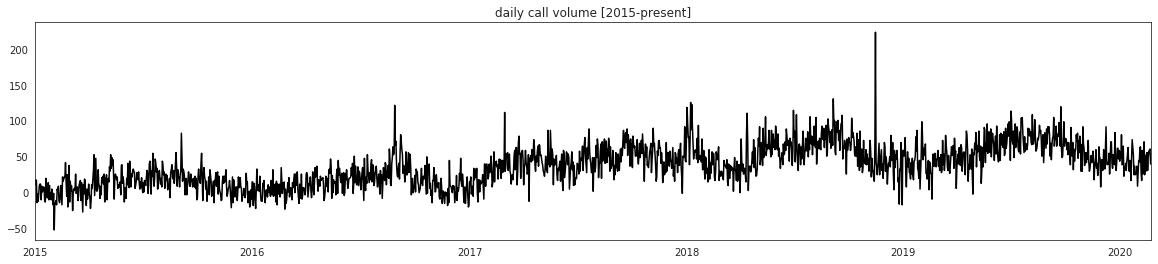

In [32]:
date_sum = ers_data['create_time_incident'].dt.date
date_sum =date_sum.value_counts()
dat_sum = (date_sum - date_sum.mean() + date_sum.std()+ 8)

#ones =(date_sum['created_minute'] - date_sum['created_minute'].mean() + date_sum['created_minute'].std()-40)
ttle = 'daily call volume [2015-present]'

#ax1.set_title(ttle)

daily_count= dat_sum.plot(kind ='line', color = 'black', figsize=(20,4), title = ttle )

plt.show()

In [0]:
date_sum = ers_data['create_time_incident'].dt.date
max_date_sum = date_sum.value_counts().head(200)

min_date_sum = date_sum.value_counts().tail(200)

all_date_sum = date_sum.value_counts()

In [0]:
lat_max = ers_data['latitude_x'].max()

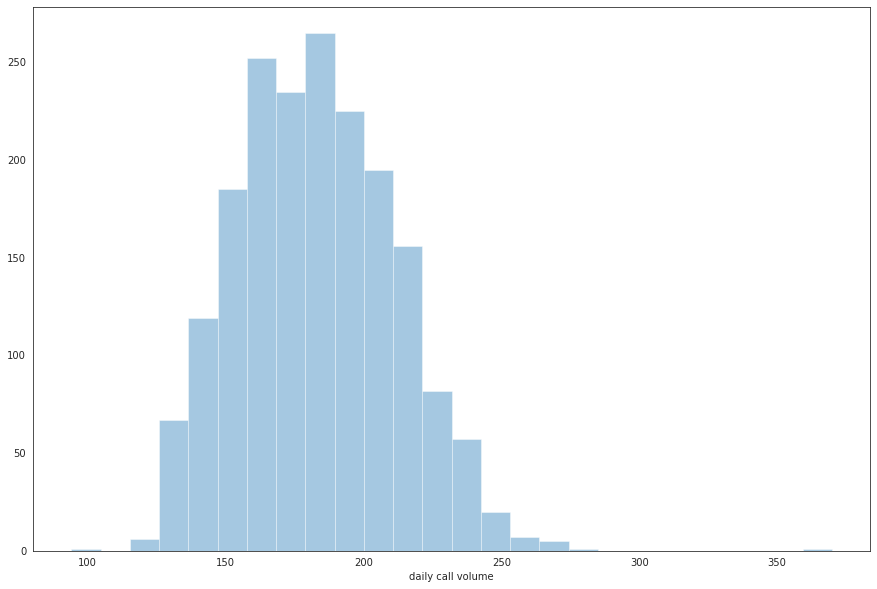

In [35]:
plt.figure(figsize=(15,10))

sns.distplot(all_date_sum, bins = 26, kde=False, rug=False, axlabel="daily call volume")
#all_date_sum.plot(kind ='hist', color = 'blue', figsize=(20,4), title = ttle )
plt.show()

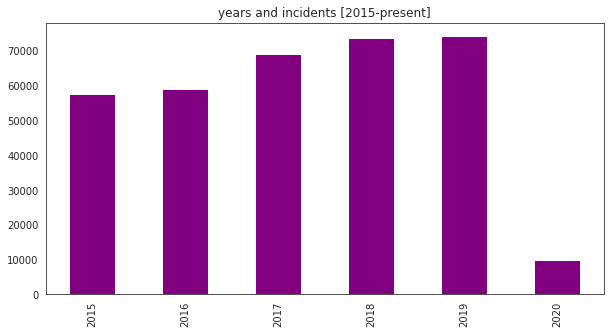

In [36]:
year_sum = createdf['created_year'].value_counts()[:12]

year_sum.sort_index(inplace =True)
ttle = 'years and incidents [2015-present]'
year_sum.plot(kind='bar', color ='purple', 
               title=ttle, figsize=(10, 5), )
plt.show()

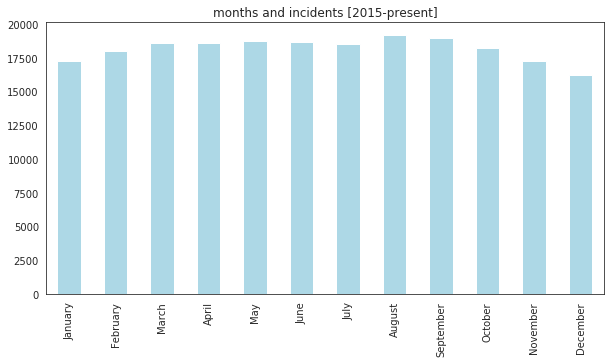

In [37]:
#@title
hour_sum = createdf['created_hour'].value_counts()[:24].to_frame()
hour_sum.sort_index(inplace =True)

month_sum = createdf['created_hour'].value_counts()[:12]

month_sum.sort_index(inplace =True)
ttle = 'months and incidents [2015-present]'
month_sum.plot(kind='bar', color ='lightblue', 
               title=ttle, figsize=(10, 5), )
plt.xticks(np.arange(12), ('January', 'February', 'March', 'April',
                           'May','June', 'July', 'August', 'September',
                           'October', 'November', 'December'))
plt.show()

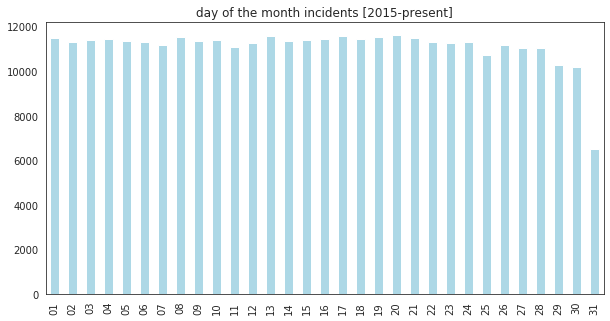

In [38]:
#@title
hour_sum = createdf['created_hour'].value_counts()[:24].to_frame()
hour_sum.sort_index(inplace =True)

day_sum = createdf['created_day'].value_counts()[:31]

day_sum.sort_index(inplace =True)
ttle = 'day of the month incidents [2015-present]'
day_sum.plot(kind='bar', color ='lightblue', 
               title=ttle, figsize=(10, 5), )
plt.show()

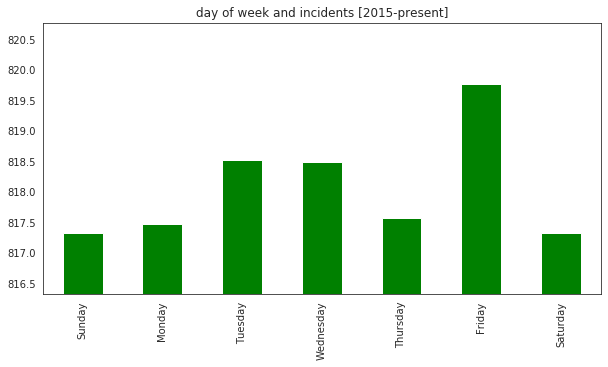

In [39]:
wkdnum_sum1 = createdf['created_day'].value_counts()[:7]
wkdnum_sum = np.power(np.log(wkdnum_sum1),3)
wkdnum_sum.sort_index(inplace =True)
ttle = 'day of week and incidents [2015-present]'
wkdnum_sum.plot(kind='bar', color ='green', 
               title=ttle, figsize=(10, 5), )
plt.xticks(np.arange(7), ('Sunday', 'Monday', 'Tuesday', 'Wednesday', 
                          'Thursday','Friday', 'Saturday'))
plt.ylim(wkdnum_sum.min()-1,wkdnum_sum.max()+1)
plt.show()

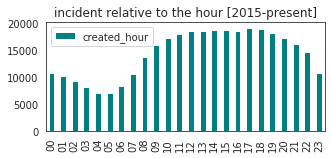

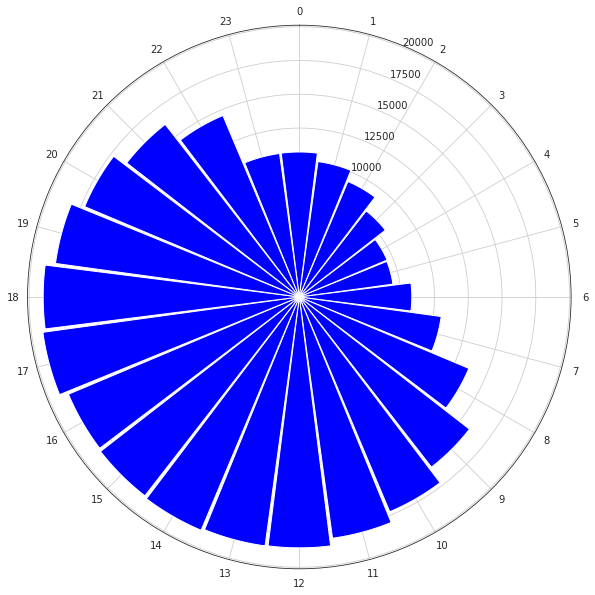

In [40]:
#@title
ttle2 = "incident relative to the hour [2015-present]"
hour_sum.plot(kind='bar', color ='teal', title= ttle2,
              figsize=(5, 2), )
plt.show()

plt.figure(figsize=(10,10))

ax = plt.subplot(111, polar=True)
equals = np.linspace(0, 360, 24, endpoint=False) #np.arange(24)
ones =hour_sum['created_hour']
ax.bar(np.deg2rad(equals), ones, color ='blue', width =.25)       

# Set the circumference labels
ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
ax.set_xticklabels(range(24))      

# Make the labels go clockwise
ax.set_theta_direction(-1)       

# Place 0 at the top
ax.set_theta_offset(np.pi/2.0)       

plt.show()

In [0]:
#@title
min_sum = createdf['created_minute'].value_counts()[:60].to_frame()
min_sum.sort_index(inplace =True)

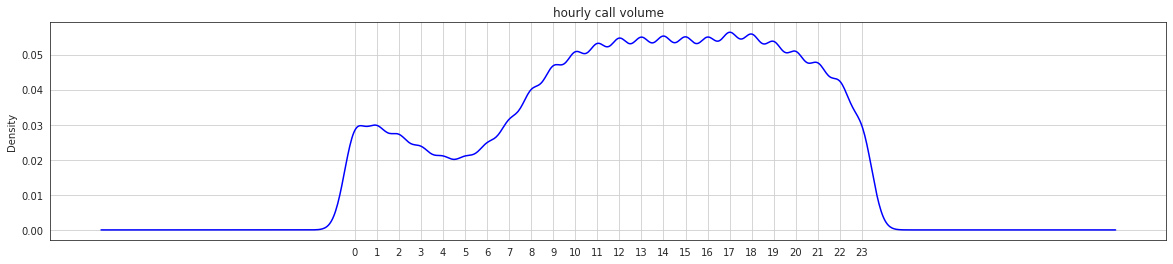

In [42]:
hour_all_sum = ers_data['create_time_incident'].dt.hour

hour_all_sum.plot(kind ='kde', color = 'blue', figsize=(20,4), grid = True,  title = "hourly call volume" )
plt.xticks(np.arange(0, 24, 1.0))
plt.show()

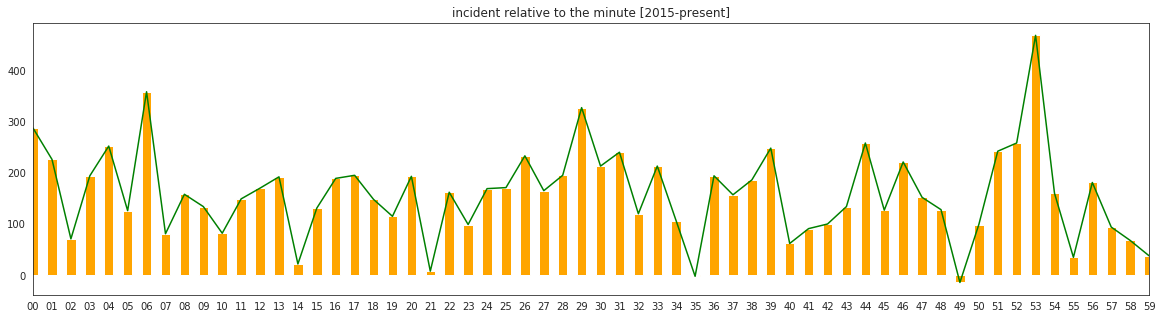

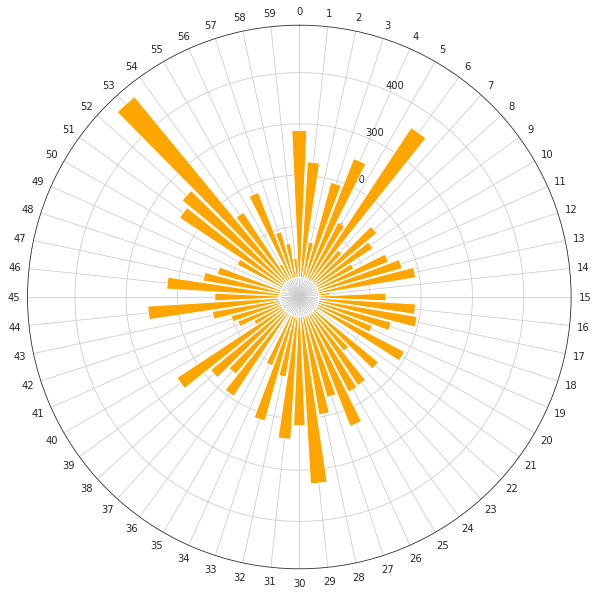

In [43]:
ttle3 = "incident relative to the minute [2015-present]"
min_sum2 =(min_sum['created_minute'] - min_sum['created_minute'].mean()+160)
min_sum2.plot(kind='bar', color ='orange', title= ttle3,
              figsize=(20, 5), )
min_sum2.plot(kind='line', color ='green', title= ttle3,
              figsize=(20, 5), )
#plt.ylim(2.5,10)
plt.show()

plt.figure(figsize=(10,10))

ax = plt.subplot(111, polar=True)
equals = np.linspace(0, 360, 60, endpoint=False) #np.arange(24)
ones =(min_sum['created_minute'] - min_sum['created_minute'].mean() + 160)
ax.bar(np.deg2rad(equals), ones, color ='orange', width =.09)       

# Set the circumference labels
ax.set_xticks(np.linspace(0, 2*np.pi, 60, endpoint=False))
ax.set_xticklabels(range(0,60,1))      

# Make the labels go clockwise
ax.set_theta_direction(-1)       

# Place 0 at the top
ax.set_theta_offset(np.pi/2.0)       

plt.show()

In [0]:
ers_data['latitude_x'] = ers_data['latitude_x'].astype(float)
ers_data['longitude_x'] = ers_data['longitude_x'].astype(float)
createdf['latitude_x'] = ers_data['latitude_x']
createdf['longitude_x'] = ers_data['longitude_x']
createdf['hour'] = hour_all_sum
createdf['count'] = 1

In [0]:
ers_data = ers_data.drop(ers_data.loc[ers_data['latitude_x']>= 39.5].index)

createdf = datime(ers_data,'create_time_incident', "testdf", "created_year", "created_month",
                "created_day", "created_weekday", "created_wkdnum", "created_hour",
                "created_minute", '%m/%d/%Y %H:%M')

In [0]:
ers_data = ers_data.drop(ers_data.loc[ers_data['longitude_x'] <=-85.5].index)

In [0]:
ers_data['created_year'] =  createdf['created_year'].astype(int)
ers_data['created_month'] =  createdf['created_month'].astype(int)
ers_data['created_day'] =  createdf['created_day'].astype(int)
ers_data['created_weekday'] =  createdf['created_weekday']
ers_data['created_wkdnum'] =  createdf['created_wkdnum'].astype(int)
ers_data['created_hour'] =  createdf['created_hour'].astype(int)
ers_data['created_minute'] =  createdf['created_minute'].astype(int)



In [48]:
ers_data.columns

Index(['index', 'latitude_x', 'longitude_x', 'create_time_incident',
       'event_number', 'arrival_time_primary_unit', 'closed_time_incident',
       'dispatch_time_primary_unit', 'disp_time', 'call_arrive', 'disp_arrive',
       'call_duration', 'created_year', 'created_month', 'created_day',
       'created_weekday', 'created_wkdnum', 'created_hour', 'created_minute'],
      dtype='object')

In [0]:
heat_df = ers_data[ers_data['created_year']<=2017] # Reducing data size so it runs faster
heat_df = heat_df[['latitude_x', 'longitude_x']]

In [0]:
heat_df = heat_df.sample(frac=0.1)

In [0]:
createdf2 = createdf.sample( frac=0.01, weights='created_hour', random_state=1)

In [0]:

df_hour_list = []
for hour in createdf2['created_hour'].sort_values().unique():
    df_hour_list.append(createdf2.loc[createdf2.created_hour == hour, ['latitude_x', 'longitude_x', 'count']].groupby(['latitude_x', 'longitude_x']).sum().reset_index().values.tolist())

### Creating the clusters which will define the posting areas

#### First step is to run 

In [53]:
if 'gpxpy' in installed_packages:
  import gpxpy
  from geopy.distance import distance, geodesic
  
else: 
  !pip install gpxpy
  !pip install geopy
  import gpxpy
  from geopy.distance import distance, geodesic

     |████████████████████████████████| 112kB 2.8MB/s 
  Created wheel for gpxpy: filename=gpxpy-1.4.0-cp36-none-any.whl size=42812 sha256=0dd4f203940ce00076a989eaf448dcad27ac067afc59e7f1b569b0f166d47369
  Stored in directory: /root/.cache/pip/wheels/77/d7/ee/cb4d7a151ce924c35e681377fb90a0b882f55bfd3c2c586739
Successfully built gpxpy


In [0]:
# to take out of demo mode change the 'y' to 'n'
demo = 'y'

In [0]:
if demo == 'y':
  min_posts = 10
  max_posts = 25
  dist = 3
else:
  min_posts = int(input("what is the minimum posts to try?"))
  max_posts = int(input("what is the maximum posts to try?"))
  dist = int(input("what is the post-to-post distance threshold?"))



In [0]:
coord = ers_data[["latitude_x",	"longitude_x"]].values
neighbors = []
def min_distance(regionCenters, totalClusters):
    good_points = 0
    bad_points = 0
    less_dist = []
    more_dist = []
    min_distance = 100000  #any big number can be given here
    for i in range(totalClusters):
        good_points = 0
        bad_points = 0
        for j in range(totalClusters):
            if j != i:
                distance = geodesic((regionCenters[i][0], regionCenters[i][1]), (regionCenters[j][0], regionCenters[j][1])).meters
                distance = distance/(1.60934*1000)   #distance from meters to miles
                min_distance = min(min_distance, distance) #it will return minimum of "min_distance, distance".
                if distance < dist:
                    good_points += 1
                else:
                    bad_points += 1
        less_dist.append(good_points)
        more_dist.append(bad_points)
    print("On choosing a cluster size of {}".format(totalClusters))
    print("Avg. Number clusters within vicinity where inter cluster distance < {} miles is {}".format(dist, np.ceil(sum(less_dist)/len(less_dist))))
    print("Avg. Number clusters outside of vicinity where inter cluster distance > {} miles is {}".format(dist, np.ceil(sum(more_dist)/len(more_dist))))
    print("Minimum distance between any two clusters = {} miles".format(min_distance))
    print("-"*10)
            
def makingRegions(noOfRegions):
    regions = MiniBatchKMeans(n_clusters = noOfRegions, batch_size = 10000, random_state = 1).fit(coord)
    regionCenters = regions.cluster_centers_ 
    totalClusters = len(regionCenters)
    return regionCenters, totalClusters
  
  

In [57]:
coord

array([[ 39.135067, -84.519264],
       [ 39.103932, -84.514527],
       [ 39.096269, -84.521328],
       ...,
       [ 39.100433, -84.515755],
       [ 39.10128 , -84.51226 ],
       [ 39.096948, -84.507899]])

In [58]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
for clus in range(min_posts,max_posts):
  mr = makingRegions(clus)
  min_distance(mr[0], mr[1])

On choosing a cluster size of 10
Avg. Number clusters within vicinity where inter cluster distance < 3 miles is 2.0
Avg. Number clusters outside of vicinity where inter cluster distance > 3 miles is 8.0
Minimum distance between any two clusters = 2.335722594707662 miles
----------
On choosing a cluster size of 11
Avg. Number clusters within vicinity where inter cluster distance < 3 miles is 2.0
Avg. Number clusters outside of vicinity where inter cluster distance > 3 miles is 9.0
Minimum distance between any two clusters = 2.170267679233927 miles
----------
On choosing a cluster size of 12
Avg. Number clusters within vicinity where inter cluster distance < 3 miles is 2.0
Avg. Number clusters outside of vicinity where inter cluster distance > 3 miles is 10.0
Minimum distance between any two clusters = 2.186332174977902 miles
----------
On choosing a cluster size of 13
Avg. Number clusters within vicinity where inter cluster distance < 3 miles is 2.0
Avg. Number clusters outside of vicin

In [0]:
if demo == 'y':
  posts = 12
else: 
  posts =int(input("how many posts do we want to model?"))

In [0]:
mr = makingRegions(posts)
regions = MiniBatchKMeans(n_clusters = mr[1], batch_size = 10000, 
                          random_state = 1).fit(coord)

regionCenters = regions.cluster_centers_ 
totalClusters = len(regionCenters)
#print (mr)

In [61]:
print(regionCenters)


[[ 39.0908859  -84.38975277]
 [ 39.11023868 -84.51696819]
 [ 39.19328697 -84.55390825]
 [ 39.19315192 -84.46906092]
 [ 39.13817105 -84.4910076 ]
 [ 39.16620679 -84.40767539]
 [ 39.13902386 -84.59391797]
 [ 39.11031931 -84.57257391]
 [ 39.18416115 -84.51490713]
 [ 39.14582741 -84.54380848]
 [ 39.11143166 -84.68655862]
 [ 39.13844141 -84.43701447]]


In [62]:
#using the first entry in the ers_data dataframe and a slight variation to test 
#the formating needed for adding new data  

print(regions.predict([[39.0962690000897, -84.521328],
                       [39.4989930000594, -84.521329]]))

[1 2]


In [63]:
location_list = mr[0].tolist()
name_location =[]
for i in range(0,len(location_list)):
  name_location.append(i+1)
#print (location_list)
#print(name_location)
location_list[7]
print (mr[1])

12


In [64]:
# attach post_area cluster to original points
ers_data['post_area'] = regions.labels_
# Create a dataframe for cluster_centers (centroids)
centroids = pd.DataFrame(regionCenters, columns=["latitude_x", "longitude_x"])
ers_data['post_area'].value_counts().head(10)

1     71438
4     55300
7     40328
6     33658
9     31473
3     29728
5     23085
2     20882
11    14398
8     13033
Name: post_area, dtype: int64

In [65]:
centroids.shape

(12, 2)

In [66]:
ers_data.describe()

,index,latitude_x,longitude_x,disp_time,call_arrive,disp_arrive,call_duration,created_year,created_month,created_day,created_wkdnum,created_hour,created_minute,post_area
count,344014.000,344014.000,344014.000,344014,344014,344014,344014,344014.000,344014.000,344014.000,344014.000,344014.000,344014.000,344014.000
mean,208296.588,39.140,-84.515,0 days 00:00:41.879926,0 days 00:05:50.166188,0 days 00:05:08.286261,0 days 00:40:19.777224,2017.227,6.449,15.656,3.021,12.878,29.473,4.635
std,124171.791,0.032,0.057,0 days 00:02:19.628809,0 days 00:15:42.769266,0 days 00:15:30.988748,0 days 04:06:07.501338,1.460,3.447,8.772,1.990,6.303,17.319,2.983
min,0.000,38.992,-85.012,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:02,2015.000,1.000,1.000,0.000,0.000,0.000,0.000
25%,99392.250,39.114,-84.558,0 days 00:00:16,0 days 00:03:42,0 days 00:03:09,0 days 00:16:28,2016.000,3.000,8.000,1.000,9.000,14.000,2.000
50%,203674.500,39.136,-84.515,0 days 00:00:24,0 days 00:04:55,0 days 00:04:18,0 days 00:33:37,2017.000,7.000,16.000,3.000,13.000,29.000,4.000
75%,314317.750,39.159,-84.484,0 days 00:00:45,0 days 00:06:24,0 days 00:05:40,0 days 00:52:02,2018.000,9.000,23.000,5.000,18.000,44.000,7.000
max,432607.000,39.499,-84.140,0 days 09:36:43,0 days 12:18:17,0 days 12:16:32,91 days 20:40:44,2020.000,12.000,31.000,6.000,23.000,59.000,11.000


In [0]:
ers_data['post_lat'] = [centroids['latitude_x'][ers_data['post_area'][i]] for i in ers_data.index ]

In [0]:
ers_data['post_long'] = [centroids['longitude_x'][ers_data['post_area'][i]] for i in ers_data.index ]

In [0]:
ers_data['post_dist'] = [float(geodesic(
    (ers_data['latitude_x'][i],ers_data['longitude_x'][i]),
    (ers_data['post_lat'][i], ers_data['post_long'][i])).miles) for i in ers_data.index]

In [70]:
ers_data.loc[ers_data['longitude_x'] <=-85.5]

,index,latitude_x,longitude_x,create_time_incident,event_number,arrival_time_primary_unit,closed_time_incident,dispatch_time_primary_unit,disp_time,call_arrive,disp_arrive,call_duration,created_year,created_month,created_day,created_weekday,created_wkdnum,created_hour,created_minute,post_area,post_lat,post_long,post_dist


In [0]:
#centroids[['latitude_x','longitude_x']]

In [72]:
ers_data.post_dist.describe()

count   344014.000
mean         0.895
std          0.449
min          0.000
25%          0.574
50%          0.850
75%          1.185
max         27.512
Name: post_dist, dtype: float64

In [73]:
radius = ers_data.post_dist.mean() + 2*(ers_data.post_dist.std())
print(radius)

1.7929533465561418


In [74]:
print
("Removing each posts outliers (greater than {} miles from post) resulted \
in {} records ({}%) being removed".format( radius, 
                             len(ers_data.loc[ers_data.post_dist > radius]),
                             round((len(ers_data.loc[ers_data.post_dist > radius])
                             /len(ers_data))*100))
)

'Removing each posts outliers (greater than 1.7929533465561418 miles from post) resulted in 10062 records (3%) being removed'

In [0]:
ers_data = ers_data.drop(ers_data.loc[ers_data.post_dist > radius].index)

In [0]:
#print(ers_data['post_area'][:10])

In [77]:
print('latitude_x')
print('min ', ers_data['latitude_x'].min())
print('max ', ers_data['latitude_x'].max())
print((ers_data['latitude_x'].max()- ers_data['latitude_x'].min())*50)
print('longitude_x')
print('min ', ers_data['longitude_x'].min())
print('max ', ers_data['longitude_x'].max())
print((ers_data['longitude_x'].max()- ers_data['longitude_x'].min())*50)

latitude_x
min  39.0708190000598
max  39.2188250000895
7.400300001485149
longitude_x
min  -84.70946132
max  -84.36073
17.436565999999942


In [78]:
lat_center = ers_data['latitude_x'].mean()
long_center = ers_data['longitude_x'].mean()

print(lat_center)
print(long_center)
print(ers_data['latitude_x'].mean())
print(ers_data['longitude_x'].mean())


39.14008561844502
-84.51566782631622
39.14008561844502
-84.51566782631622


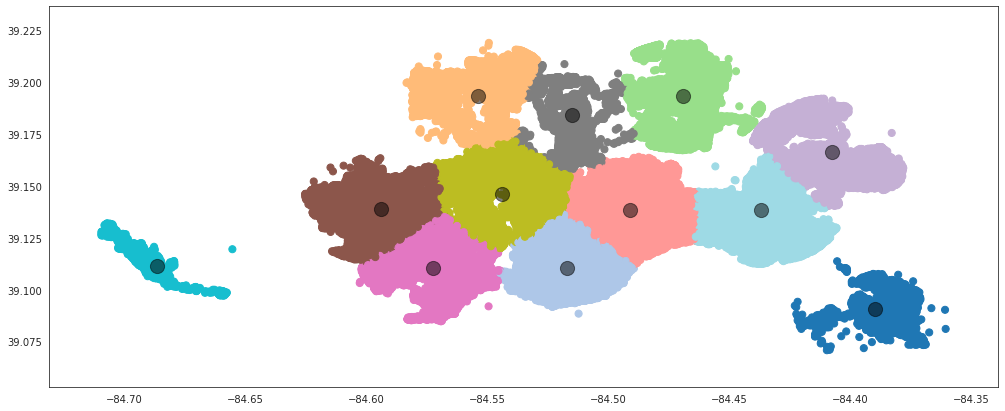

In [79]:
plt.figure(figsize=(round((ers_data['longitude_x'].max()- ers_data['longitude_x'].min())*50), round((ers_data['latitude_x'].max()- ers_data['latitude_x'].min())*50)))

clusters =plt.scatter(ers_data['longitude_x'], ers_data['latitude_x'], 
                      c = ers_data['post_area'], s=50, cmap='tab20')

centers = regions
plt.scatter(centroids['longitude_x'], centroids['latitude_x'], 
            c='black', s=200, alpha=0.5)

plt.show()


In [80]:
!pip3 install folium --upgrade
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
from IPython.display import HTML, display


     |████████████████████████████████| 92kB 3.0MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.10.1 which is incompatible.
  Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3


In [81]:
print ("Top white box in controls is: \n go back \n play in reverse \n play \n go forward")

Top white box in controls is: 
 go back 
 play in reverse 
 play 
 go forward


In [82]:

map_hooray = folium.Map(location=[lat_center,-84.5464934],
                    zoom_start = 12, min_zoom =11, max_zoom = 18, 
                    control_scale= True)

heat_data = [[row['latitude_x'],row['longitude_x']] for index, 
             row in heat_df.iterrows()]

for point in range(0, mr[1]):
    folium.Marker(location_list[point], 
                  popup = str(name_location[point]-1)).add_to(map_hooray)


HeatMap(heat_data, name=True, min_opacity=0.36, max_zoom =18, max_val=1.0, 
        radius =9, gradient={0.1: 'violet',0.3: 'blue', 
                             0.4: 'lightgreen', 0.5: 'green', 0.6: 'yellow',
                             0.7: 'orange', 0.9: 'red', 1: 'white'}, 
        blur=15,  overlay=True, control=True, show = True).add_to(map_hooray)

HeatMapWithTime(df_hour_list, radius=10,  min_opacity =0, max_opacity=1, 
                scale_radius=False, min_speed = 0.1, max_speed=10, 
                speed_step=0.1, position="bottomleft", overlay=True, 
                control=True, show=True, auto_play=True).add_to(map_hooray)

map_hooray




In [0]:
ers_data_exp= ers_data.copy(deep=True)

In [0]:
ers_data_exp.to_pickle(".\ers_data_exp")

In [0]:
ers_data = pd.read_pickle(".\ers_data_exp")

In [0]:
ers_data = ers_data.drop(['event_number', 'arrival_time_primary_unit',
                          'closed_time_incident', 'dispatch_time_primary_unit',
                          'disp_time', 'call_arrive', 'disp_arrive',
                          'call_duration'], axis =1)

In [0]:
#ers_data.head()

In [88]:
ers_data['created_year'].describe()

count   333952.000
mean      2017.226
std          1.461
min       2015.000
25%       2016.000
50%       2017.000
75%       2018.000
max       2020.000
Name: created_year, dtype: float64

In [0]:
ers_data['unix_create'] = ers_data['create_time_incident'].astype(np.int64)/ 10**9

In [90]:
ers_data['unix_create'].min()

1420070572.0

In [91]:
ers_data['unix_create'].max()

1582415202.0

In [92]:
ers_data['unix_create'].max()-(ers_data['unix_create'].min())

162344630.0

### Division of Data

#### The data set will be divided into post locations and ran independently of each other.  When attempting to keep the data together as one data set the accuracy and precision of the results was very low and the data was hard to balance.  

In [0]:
def value_isol(dataframe, variable, val):
  temp_frame = dataframe.loc[dataframe[variable] == val]
  print('isolating post data for the {} post'.format(val+1))
  print('entries for post {}: {}'.format(val+1, len(temp_frame)))
  return temp_frame

In [94]:
post_1 = value_isol(ers_data, 'post_area', 0)



isolating post data for the 1 post
entries for post 1: 7531


In [95]:
post_1.head()

,index,latitude_x,longitude_x,create_time_incident,created_year,created_month,created_day,created_weekday,created_wkdnum,created_hour,created_minute,post_area,post_lat,post_long,post_dist,unix_create
114,119,39.085,-84.390,2018-12-23 19:45:37,2018,12,23,Sunday,0,19,45,0,39.091,-84.390,0.386,1545594337.000
167,174,39.076,-84.372,2018-07-06 04:49:57,2018,7,6,Friday,5,4,49,0,39.091,-84.390,1.396,1530852597.000
168,175,39.086,-84.382,2018-03-06 11:55:11,2018,3,6,Tuesday,2,11,55,0,39.091,-84.390,0.533,1520337311.000
300,312,39.098,-84.386,2017-02-15 18:12:45,2017,2,15,Wednesday,3,18,12,0,39.091,-84.390,0.539,1487182365.000
424,439,39.086,-84.391,2019-05-03 03:21:02,2019,5,3,Friday,5,3,21,0,39.091,-84.390,0.336,1556853662.000


In [0]:
maxuni=ers_data['unix_create'].max()

#int((maxuni-1420070400)/(60*bin_length))


### Creating the bins of time we will use for our prediction modeling
#### Because we are wanting to predict where calls are most likely to occur next we do need to pay attention to how big/small (number of minutes our bins are.  If we divide the time into relatively small bins we will find that a majority of the bins are empty making and the processing time will be very long.  If we pick relatively large bins we will have more incidents in each bin and the processing time is much shorter but we also lose the practical value of the prediction.

In [0]:
if demo == 'y':
  bin_length = 90
else: 
  bin_length = input("How long, in minutes, should each period of time be? \
  (240 or higher 240, 360, 480, 600, 720)")

In [0]:
def unix_cre_times(dataframe):
  unix_create_times=[i for i in dataframe['unix_create'].values]
  unix_create_times[:5]
  minute_bin_create_times = [int((i-1420070400)/(60*bin_length)) for i in unix_create_times]
  print("Post {}:\n Our {} minute bins range from Min = {}, Max ={}".format(int(dataframe['post_area'].mean())+1, bin_length,
                  min(minute_bin_create_times), max(minute_bin_create_times)))
  return minute_bin_create_times

In [0]:
def creating_unix_time_bin(dataframe,bin_length):
  temp = dataframe.copy()
  temp['unix_create'] = temp['create_time_incident'].copy()\
  .astype(np.int64)/ 10**9
  unix_created_time = [i for i in temp['unix_create'].values]
  unix_create_times=[i for i in temp['unix_create'].values]
  minute_bin_create_times = [int((i-1420070400)/(60*bin_length)) for i in unix_create_times]

  minutewise_bin_unix_time = [int((i-1420070400)/(60*bin_length))\
                              for i in unix_created_time]
  temp2 = dataframe.copy()
  temp2['time_bin'] = np.array(minutewise_bin_unix_time)

  print('total expected time bins for the bin length of {} minutes is {} and {} bins for\
  the post'.format(bin_length, max(minute_bin_create_times), 
                        max(minute_bin_create_times)*posts ))
  print('**--**')
  print('')
  
  return temp2['time_bin']

In [102]:
post_1['time_bin']= creating_unix_time_bin(post_1, bin_length).copy()

total expected time bins for the bin length of 90 minutes is 30060 and 360720 bins for  the post
**--**



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
#ers_bin_groupby2=ers_bin_data.groupby(["post_area", "time_bin"] as_index=False).created_wkdnum.agg('median')

In [110]:
#unix_create_times=[i for i in post_1['unix_create'].values]
#minute_bin_create_times = [int((i-1420070400)/(60*bin_length)) for i in [i for i in post_1['unix_create'].values]]
#max_bins = max(minute_bin_create_times)
#print(max_bins)
#empty_bins = max_bins-len(post_1b_groupby)
#print('We currently have {} total time bins populated for the post leaving \
#{} empty time bins.'
#.format(len(post_1b_groupby), empty_bins))

30060
We currently have 6523 total time bins populated for the post leaving 23537 empty time bins.


In [0]:
def return_unq_pickup_bins(dataframe):
    vals = []
    new = dataframe[dataframe['post_area'] == i]
    list_unq = list(set(dataframe['time_bin']))
    list_unq.sort()
    vals.append(list_unq)

    #summation = 0
    #summation = (max(minute_bin_create_times)-len(vals))
    #frame_unique = vals
    #print ('total number of bins with zero incidents: {}'.format(summation))

    #print ('list of the number of zero incident bins per cluster \n')
    #print ('_'*74)
    #for i in range(posts):
     #print ("for {}th cluster, number of {} minute interval with zero pickups: \
     # {}".format(i, bin_length,max(minute_bin_create_times)-len(vals[i])))
      #print('_'*74)

  
    return list_unq

In [0]:
def fill_missing(count_values,vals):
    smoothed_regions=[]
    ind=0  # ind iterates over count_values only
    smoothed_bins=[]
    for i in range(max(minute_bin_create_times)):
        if i in vals:
            smoothed_bins.append(count_values[ind])
            ind+=1
        else:
            smoothed_bins.append(0)
    smoothed_regions.extend(smoothed_bins)
    
    return smoothed_regions

In [0]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [0]:
def ma_pred(dataframe,window_size):
  print('For {} window:'.format(window_size))
  dataframe['m_ave_pred'] = round(dataframe.iloc[:,0].rolling(window=window_size, ).mean()).fillna(0)
  y_true = dataframe['prediction']
  y_pred = dataframe['m_ave_pred']
  ma_acc = accuracy_score(dataframe['prediction'], dataframe['m_ave_pred'], )
  ma_prec =precision_score(dataframe['prediction'], dataframe['m_ave_pred'], average= 'weighted', zero_division= 0)
  ma_recall = recall_score(dataframe['prediction'], dataframe['m_ave_pred'], average= 'weighted')
  dataframe['mape']= abs(dataframe['prediction']-dataframe['m_ave_pred'])
  print(confusion_matrix(y_true, y_pred, ))
  print(classification_report(y_true, y_pred, ))
  sqr_err = dataframe['mape']**2
  
  return dataframe,ma_acc,ma_prec, ma_recall, sqr_err


In [0]:
def wma_pred(dataframe, window_size):
  print('For {} window:'.format(window_size))
  weights = np.arange(1,window_size+1)
  dataframe['wma_pred'] = round(dataframe['prediction'].rolling(window_size).apply(lambda preds: np.dot(preds, weights)/weights.sum(), raw=True)).fillna(0)
  y_true = dataframe['prediction']
  y_pred = dataframe['wma_pred']
  wma_acc = accuracy_score(dataframe['prediction'], dataframe['wma_pred'], )
  wma_prec =precision_score(dataframe['prediction'], dataframe['wma_pred'], average= 'weighted', zero_division= 0)
  wma_recall = recall_score(dataframe['prediction'], dataframe['wma_pred'], average= 'weighted')
  dataframe['wape']= abs(dataframe['prediction']-dataframe['wma_pred'])
  print(confusion_matrix(y_true, y_pred, ))
  print(classification_report(y_true, y_pred, ))
  wmasqr_err = dataframe['wape']**2
  
  return dataframe,wma_acc,wma_prec, wma_recall, wmasqr_err
  

In [0]:
def ewa_pred(dataframe, al):
  print('For alpha of {}:'.format(al))
  alph_list = np.arange(.1,1,50)
  dataframe['ewa_pred']= round(dataframe['prediction'].ewm(alpha=al).mean()).fillna(0)
  y_true = dataframe['prediction']
  y_pred = dataframe['ewa_pred']
  ewa_acc = accuracy_score(dataframe['prediction'], dataframe['ewa_pred'], )
  ewa_prec =precision_score(dataframe['prediction'], dataframe['ewa_pred'],average= 'weighted', zero_division= 0)
  ewa_recall = recall_score(dataframe['prediction'], dataframe['ewa_pred'], average= 'weighted')
  dataframe['ewape']= abs(dataframe['prediction']-dataframe['ewa_pred'])
  print(confusion_matrix(y_true, y_pred, ))
  print(classification_report(y_true, y_pred, ))
  ewasqr_err = dataframe['ewape']**2
  
  return dataframe,ewa_acc,ewa_prec, ewa_recall, ewasqr_err

In [0]:
def f_var(dataframe, variable):
  f_val = [] 
  fin = []
  for bins in range(0,smax_bins):
    f_val.append(int(dataframe[variable][bins]))
    #print("length so far")
    #print (len(f_val))
  fin = f_val
  print(len(fin))
  return fin
 

In [0]:
def tes_var(variable):
  test_variable = variable[train_bins:]
  print(len(test_variable))
  return test_variable


def tra_var(variable):
  train_variable = variable[:train_bins] 
  print(len(train_variable))
  return train_variable

In [191]:
colz = ['bin-48','bin-47','bin-46','bin-45','bin-44','bin-43','bin-42',
        'bin-41','bin-40','bin-39','bin-38','bin-37','bin-36','bin-35',
        'bin-34','bin-33','bin-32','bin-31','bin-30','bin-29','bin-28',
        'bin-27','bin-26','bin-25','bin-24','bin-23','bin-22','bin-21',
        'bin-20','bin-19','bin-18','bin-17','bin-16','bin-15','bin-14',
        'bin-13','bin-12','bin-11','bin-10','bin-9','bin-8','bin-7','bin-6',
        'bin-5','bin-4','bin-3','bin-2','bin-1',]
cols = colz[-past:]
print('features we will add to prediction dataframe')
print(cols)

features we will add to prediction dataframe
['bin-32', 'bin-31', 'bin-30', 'bin-29', 'bin-28', 'bin-27', 'bin-26', 'bin-25', 'bin-24', 'bin-23', 'bin-22', 'bin-21', 'bin-20', 'bin-19', 'bin-18', 'bin-17', 'bin-16', 'bin-15', 'bin-14', 'bin-13', 'bin-12', 'bin-11', 'bin-10', 'bin-9', 'bin-8', 'bin-7', 'bin-6', 'bin-5', 'bin-4', 'bin-3', 'bin-2', 'bin-1']


In [0]:
from sklearn.linear_model import SGDClassifier as clf
from sklearn.ensemble import RandomForestClassifier as rfc
import xgboost as xgb

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [0]:
#x_train = d_train.drop(columns = ('day_year'))

In [244]:
# Creates the isolated posts and then preps for the models by filling in data 
# for time bins without recorded incidents for the post

# this function returns a dataframe

# 'cluster' is the numerical cluster number attached to the 
# post in ers_data['post_area']

# changing the value of 'demo' to 'n' will allow the user to input
# their own value for the time bin. 

demo = 'y'

def post_prep(cluster,):
  
  data_isol = value_isol(ers_data, 'post_area', cluster)

  data_isol.head(10)
  #Allows for user input for the size of the time bins if not in demo mode. 
  if demo == 'y':
    bin_length = 90
  else: 
    bin_length = input("How long, in minutes, should each period of time be? \
    (240 or higher 240, 360, 480, 600, 720)")

# creating the time bins for the post we have chosen
  print('creating time bins')
  print('**--**'*20)

  data_isol['time_bin']= creating_unix_time_bin(data_isol, bin_length)

  maxuni=ers_data['unix_create'].max()
  all_max_bins= int((maxuni-1420070400)/(60*bin_length))

# using the groupby function and an aggregation to create 
#the number of incidents per time bin in the post
  #print('running groupby')
  #print('**--**'*20)

  post_groupby = data_isol.groupby(\
                                   ["post_area", "time_bin"],as_index=False)\
                                   .longitude_x.agg({"no_of_incidents":'count'})

#creating variable called "incidents" which represents stores wether the 
#number of incidents is greater than the average plus adjusted by 
#half of the standard deviation

  #print('creating incident variable')
  cat = {1:1,0:0}
  categ =round(post_groupby['no_of_incidents']
               .mean()- post_groupby['no_of_incidents'].std()/2)
  
  post_groupby['incidents']=[cat.get(i, 2) for i in post_groupby['no_of_incidents']]
  print('pivot point for T/F: ', categ)
  print('mean for incidents: ', post_groupby['incidents'].mean())
  print('**--**'*20)


  unix_create_times=[i for i in data_isol['unix_create'].values]
  minute_bin_create_times = [int((i-1420070400)/(60*bin_length)) \
                             for i in unix_create_times]
  max_bins = all_max_bins                           
#  max_bins = max(minute_bin_create_times)
  #print(max_bins)
  empty_bins = max_bins-len(post_groupby)
  print('We currently have {} total time bins populated for the post leaving \
  {} empty time bins.'
  .format(len(post_groupby), empty_bins))

# Creating the list of time bins with data about incidents so we can fill the 
# they empty time bins

  print('creating list of time bins with recorded incidents')
  print('**--**'*20)

  
  post_unique = return_unq_pickup_bins(data_isol)


# Filling in the empty entries for 'incidents' for all time bins

  print('Filling in 0 for all empty incident entries for all time bins \
  for the post')
  print('**--**'*20)


  smoothed_regions=[]
  ind=0  # ind iterates over count_values only
  smoothed_bins=[]
  for i in range(max_bins):
    if i in post_unique:
        smoothed_bins.append(post_groupby['incidents'].values[ind])
        ind+=1
    else:
      smoothed_bins.append(0)
  smoothed_regions.extend(smoothed_bins)

  data_isol_smoothed = smoothed_regions

  minutes=bin_length*len(data_isol_smoothed)
  days= minutes/(24*60)
  years=days/365
  print('')
  print("number of {} min intervals for post number {}"
  .format(bin_length,cluster+1, len(data_isol_smoothed)))
  print("which is {} total minutes or {} days or {} years"
  .format(minutes, days, years))
  print('**--**'*20)


# Creating a base dataframe to create the baseline models with 
  
  print('creating the baseline dataframe for use with the baseline models')
  print('**--**'*20)



  post_base = pd.DataFrame()
  post_base['prediction'] = data_isol_smoothed

# creating hour/day/day_o_year factors
  hour_factor = bin_length/60
  day_factor = bin_length/(60*24)
  day_o_yr = bin_length//(60*24*365)

# creating the hour, day of the year and day of the week variables
  

  post_base['hour'] = post_base['prediction']
  post_base['day_year'] = post_base['prediction']
  post_base['day_week'] = post_base['prediction']

  d=12
  for i in range(len(post_base)):
    if ((d)*bin_length)//(60*24) <= 365:
      post_base['day_year'][i] = ((d)*bin_length)//(60*24)
      d += 1
    else: 
      d=1
      post_base['day_year'][i] = ((d)*bin_length)//(60*24)
      d+=1

  e=48
  for i in range(len(post_base)):
    if ((e)*bin_length)//(60*24) <= 7:
      post_base['day_week'][i] = ((e)*bin_length)//(60*24)
      e += 1
    else: 
      e=12
      post_base['day_week'][i] = ((e)*bin_length)//(60*24)
      e+=1

  f=1
  for i in range(len(post_base)):
    if ((f)*bin_length)//(60) <= 24:
      post_base['hour'][i] = ((f)*bin_length)//(60)
      f += 1
    else: 
      f=1
      post_base['hour'][i] = ((f)*bin_length)//(60)
      f+=1
  print('base dataframe completed')
  print('**--**'*20)
 

  #print('running the moving average model')
  print('****---- post {} mean average ----****'.format(cluster))
  #for i in range(2,5):
  
  test,ma_acc,ma_prec, ma_recall, sqr_err = ma_pred(post_base,2)
  #print('For {} window:'.format(i))
  print('Accuracy:{}, precision {}, recall {}, RMSE: {}'
  .format(ma_acc, ma_prec, ma_recall, np.sqrt(sqr_err.sum()/len(sqr_err))))

  #print('running the weighted average model')
  print('****---- post {} weighted mean average ----****'.format(cluster))
  #for i in range(2,5):
  
  test,wma_acc,wma_prec, wma_recall, wmasqr_err = wma_pred(post_base,2)
  #print('For {} window:'.format(i))
   print('Accuracy:{}, precision {}, recall {}, RMSE: {}'
  .format(wma_acc, wma_prec, wma_recall, 
          np.sqrt(wmasqr_err.sum()/len(wmasqr_err))))
    
  
  
  #print('running the exponentail weighted average model')
  print('****---- post {} exponential weighted mean average ----****'.format(cluster))
  #for i in alph_list:
  test, ewa_acc, ewa_prec, ewa_recall, ewasqr_err = ewa_pred(post_base,.495)
  #print('For {} window:'.format(i))
  print('Accuracy:{}, precision {}, recall {}, RMSE: {}'
  .format(ewa_acc, ewa_prec, ewa_recall, 
          np.sqrt(ewasqr_err.sum()/len(ewasqr_err))))



  # Another opportunity for user input if not in demo mode
  print('defining the number of previous time bins to use for advanced models')
  print('**--**'*20)



  if demo == 'y':
    past = int(48//(bin_length/60))
  else: past =input('how many previous time bins (up to 48) to use for prediction?')

  print('number of prior time bins {}'.format(past))
  print('')
  rsp_areas = data_isol_smoothed.copy()

  print('creating the maximum bins after adjusting for the number of prior bins\
  being used')
  smax_bins=(all_max_bins)-past
  print('**--**'*20)


# Creating the list of lat and long to be used to create the variables
  print('Creating precursor of the variables lat and long')

  lat = []
  long = []

  lat.append(([regions.cluster_centers_[cluster][0]])*smax_bins)
  long.append(([regions.cluster_centers_[cluster][1]])*smax_bins)
  print(len(lat[0]))
  print(len(long[0]))
  print('**--**'*20)


# Creating the bins of the last n time periods incident counts 
#for each time period

  print('creating the lists of the past incident counts for each time bin')
 
  p_bins = []
  for r in range(0,smax_bins):
    p_bins.append(rsp_areas[r:r+past])

  print('Response areas:{}\nprevious data: {}\nfirst entry in the first list in p_bins: {}'
  .format(len(p_bins), len(p_bins[0]), (p_bins[0])))

  ps6_bins = p_bins

  print('**--**'*20)


  print('creating the output(target variable)')

# Creating the ouput variable to use as our prediction
# out needs adjusted/aligned for the time bins that we cannot use due to the 
#"past" time bins being incorporated in our variables. 

  out = rsp_areas[past:]

  print('**--**'*20)



  
# creating the variables for: 
# exponentially weighted average
# hour of the day 
# day of the year
# day of thew week( numerical value)

  print('creating variables for exponential weighted average, hour of day, \
  day of year, day of the week')
  def f_var(dataframe, variable):
    f_val = [] 
    fin = []
    for bins in range(0,smax_bins):
      f_val.append(int(dataframe[variable][bins]))
      #print("length so far")
      #print (len(f_val))
    fin = f_val
    print(len(fin))
    return fin

  wma_pred_vals = f_var(post_base,'wma_pred')
  hour_f = f_var(post_base,'hour')
  day_year_f = f_var(post_base,'day_year')
  day_week_f = f_var(post_base,'day_week')

  print('**--**'*20)


# creating the training/test features which will contain the past predictions

  print('creating the past prediction features for training and test data sets')

  tot_bins = len(lat[0])
  train_bins = int(tot_bins*0.7)
  test_bins = tot_bins-train_bins

  train_feat = ps6_bins[0:train_bins]

  test_feat = ps6_bins[train_bins:]

  print('test set')
  print('bins: {}'.format(len(test_feat)))
  print('features: {}'.format(len(test_feat[0])))

  print('train set')
  print('bins: {}'.format(len(train_feat)))
  print('features: {}'.format(len(train_feat[0])))
  print('**--**'*20)

  def tes_var(variable):
    test_variable = variable[train_bins:]
    return test_variable


  def tra_var(variable):
    train_variable = variable[:train_bins] 
    return train_variable
# creating the remaining variables for test and train data sets

  print('creating the remaining variables for the test and train data sets')


  lat_test = tes_var(lat[0])
  long_test = tes_var(long[0])
  out_test = tes_var(out)
  hour_test = hour_f[train_bins:]
  day_year_test = day_year_f[train_bins:]
  day_week_test = day_week_f[train_bins:]
  wma_test= wma_pred_vals[train_bins:]

  lat_train = tra_var(lat[0])
  long_train = tra_var(long[0])
  out_train = tra_var(out)
  hour_train = hour_f[:train_bins]
  day_year_train = day_year_f[:train_bins]
  day_week_train = day_week_f[:train_bins]
  wma_train = wma_pred_vals[:train_bins]

  print('Validating process: \nThe number of test features({}) should be equal \
  to {}, the number of past values to we selected.'
  .format(len(train_feat[1]), past))
  print('**--**'*20)

  tra_flat_feat = train_feat
  tes_flat_feat = test_feat

# adding the past predictions as features
  
  

  colz = ['bin-48','bin-47','bin-46','bin-45','bin-44','bin-43','bin-42',
        'bin-41','bin-40','bin-39','bin-38','bin-37','bin-36','bin-35',
        'bin-34','bin-33','bin-32','bin-31','bin-30','bin-29','bin-28',
        'bin-27','bin-26','bin-25','bin-24','bin-23','bin-22','bin-21',
        'bin-20','bin-19','bin-18','bin-17','bin-16','bin-15','bin-14',
        'bin-13','bin-12','bin-11','bin-10','bin-9','bin-8','bin-7','bin-6',
        'bin-5','bin-4','bin-3','bin-2','bin-1',]
  cols = colz[-past:]
  print('features we will add to prediction dataframe')
  print(cols)

  print('**--**'*20)


# creates the train and test data sets and populates it with past predictions

  d_train = pd.DataFrame(data = tra_flat_feat, columns = cols)

  d_test = pd.DataFrame(data = tes_flat_feat, columns = cols)

  print('test and train data sets created and ready to be populated')
  

# adding all remaining features to test and train data sest
  print('hour_train ', len(hour_train))
  print(len(d_train))
  print('hour_test ', len(hour_test))
  print(len(d_test))
  print(hour_test[0])
  print(hour_test[-1])

  #d_train['lat'] = lat_train
  #d_train['long'] = long_train
  d_train['hour']  = hour_train
  d_train['day_year'] = day_year_train
  d_train['day_week'] = day_week_train
  d_train['wma'] = wma_train
  y_train = out_train
  #d_train['output'] = y_train
  print(d_train.shape)

  print('The test data set for post {} is complete'.format(cluster))

  #d_test['lat'] = lat_test
  #d_test['long'] = long_test
  d_test['hour']  = hour_test
  d_test['day_year'] = day_year_test
  d_test['day_week'] = day_week_test
  d_test['wma'] = wma_test
  y_true = out_test
  #d_test['output'] = y_true
  print(d_test.shape)

  print('The test data set for post {} is complete'.format(cluster))

  tscv = TimeSeriesSplit(n_splits= 5)

  print('**--**'*20)
  print('**--**'*20)

  clf_ers=clf(  alpha=10, average=False, class_weight=None, epsilon=0.1,
              eta0=0.0, fit_intercept=True, l1_ratio=0.15, 
              learning_rate='optimal', loss='squared_hinge', n_iter_no_change=5, 
              n_jobs=-1, penalty='elasticnet', power_t=0.5, random_state=1, 
              early_stopping = True, shuffle=True, verbose=0, 
              warm_start=False).fit(d_train,y_train)

  cparam_search = {'alpha': [5, 1, .1], 
                 'loss': ['hinge', 'squared_hinge'],
                 'penalty': ['l1','elasticnet'],
                 'l1_ratio': [0.2, 0.3]          
                }

  gcsearch = GridSearchCV(estimator=clf_ers, cv=tscv, param_grid=cparam_search,
                        scoring='precision',
                        n_jobs = -1, verbose = 2 )

#  gcsearch.fit(d_train, y_train)
#  print(gcsearch.best_estimator_)

  #print(gcsearch.get_params)
  
  clf_ers=clf(alpha=1, average=False, class_weight=None, early_stopping=True, 
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.4, 
              learning_rate='optimal', loss='squared_hinge', max_iter=1000, 
              n_iter_no_change=5, n_jobs=-1, penalty='elasticnet', power_t=0.5, 
              random_state=1, shuffle=True, tol=0.0001, validation_fraction=0.1, 
              verbose=0, warm_start=False).fit(d_train,y_train)

  train_clf_pred = clf_ers.predict(d_train)

  test_clf_pred = clf_ers.predict(d_test)
  
  print('Training scores for stochastic gradient descent SVM')
  clftr_acc = accuracy_score(y_train, train_clf_pred, )
  clftr_prec =precision_score(y_train, train_clf_pred, average= 'weighted', zero_division= 0)
  clftr_recall = recall_score(y_train, train_clf_pred, average= 'weighted')
  print(confusion_matrix(y_train, train_clf_pred ))
  print(classification_report(y_train, train_clf_pred ))
  print("Training score for stochastic gradient descent is: {}"
  .format(clf_ers.score(d_train,y_train)))
  
  print('Test scores for stochastic gradient descent SVM')
  clfte_acc = accuracy_score(y_true, test_clf_pred, )
  clfte_prec =precision_score(y_true, test_clf_pred,average= 'weighted', zero_division= 0)
  clfte_recall = recall_score(y_true, test_clf_pred, average= 'weighted')
  print(confusion_matrix(y_true, test_clf_pred ))
  print(classification_report(y_true, test_clf_pred ))

  print("Test score for stochastic gradient descent is: {}"
  .format(clf_ers.score(d_test,y_true)))
  
  post_clf_test_precision = clfte_prec
  post_clf_train_precision = clftr_prec

  
  
  print('**--**'*20)
  print('**--**'*20)

  for_ers = rfc( max_features='sqrt',min_samples_leaf=4,min_samples_split=3,
                n_estimators=40, n_jobs=-1)
  fparam_search = {'max_depth': [5, 10, 15], 
                 'max_features': [2,3],
                 'min_samples_leaf': [3,4,5],
                 'min_samples_split': [5,6],
                 'n_estimators': [10,25,50,100]
                }

  gfsearch = GridSearchCV(estimator=for_ers, cv=tscv, param_grid=fparam_search, 
                          scoring='precision', 
                          n_jobs = -1, verbose = 2)

#  gfsearch.fit(d_train, y_train)
#  print(gfsearch.best_estimator_)

#  print(-gfsearch.best_score_)

  for_ers = rfc( bootstrap=True, ccp_alpha=0.0, class_weight=None, 
                criterion='gini', max_depth=50, max_features=2, 
                max_leaf_nodes=None, max_samples=None, 
                min_impurity_decrease=0.0, min_impurity_split=None, 
                min_samples_leaf=4, min_samples_split=6, 
                min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1, 
                oob_score=False, random_state=1, verbose=1, warm_start=False
                ).fit(d_train,y_train)

  train_for_pred = for_ers.predict(d_train)

  test_for_pred = for_ers.predict(d_test)

  print('Training scores for random forest')
  fortr_acc = accuracy_score(y_train, train_for_pred )
  fortr_prec =precision_score(y_train, train_for_pred,labels=np.unique(train_for_pred), average= 'weighted', zero_division= 0)
  fortr_recall = recall_score(y_train, train_for_pred, average= 'weighted')
  print(confusion_matrix(y_train, train_for_pred ))
  print(classification_report(y_train, train_for_pred ))
  print("Training score for random forest is: {}"
  .format(for_ers.score(d_train,y_train)))
  
  print('Test scores random forest')
  forte_acc = accuracy_score(y_true, test_for_pred )
  forte_prec =precision_score(y_true, test_for_pred, labels=np.unique(test_for_pred), average= 'weighted', zero_division= 0)
  forte_recall = recall_score(y_true, test_for_pred, average= 'weighted')
  print(confusion_matrix(y_true, test_for_pred ))
  print(classification_report(y_true, test_for_pred ))
  print("Test score for random forest is: {}"
  .format(for_ers.score(d_test,y_true)))
  
  post_for_test_precision = forte_prec
  post_for_train_precision = fortr_prec

  feat_imp = for_ers.feature_importances_
  feat_list = pd.DataFrame(columns =['feature', 'importance'])
  feat_list['feature'] = d_train.columns
  feat_list['importance'] = feat_imp


  plt.figure(figsize =(20,10))
  sns.barplot(y=feat_list.feature, x= feat_list.importance)

  print('**--**'*20)
  print('**--**'*20)

  xgb_ers = xgb.XGBClassifier(objective ='reg:logistic', eval_metric='error', 
                              max_depth = 5, min_child_weight = 1, gamma = 0.1, 
                              subsample= 0.8, colsample_bytree = 0.8, 
                              scale_pos_weight = 1, random_state = 1)

  param_search = {'max_depth':[2], 'min_child_weight':[1,2], 
                  'n_estimators':[200], 
                  'objective': ['reg:logistic', 'binary:logistic'],
                  'gamma':[.1], 
                  'subsample':[i/100.0 for i in range(70,75)], 
                  'colsample_bytree':[.7,.8], 
                  'reg_lambda':[1], 
                  'reg_alpha':[i/10000.0 for i in range(0,3)]
                }


  gxsearch = GridSearchCV(estimator=xgb_ers, cv=tscv, verbose =2,
                        param_grid=param_search, 
                        scoring='precision',n_jobs = -1)

#  gxsearch.fit(d_train, y_train)
#  print(gxsearch.best_estimator_)

  #print(-gxsearch.best_score_)



  xgb_ers = xgb.XGBClassifier(base_score=0.5, booster='gbtree', 
                              colsample_bylevel=1, colsample_bynode=1, 
                              colsample_bytree=0.7, eval_metric='error', 
                              gamma=0.1, learning_rate=0.1, max_delta_step=0, 
                              max_depth=2, min_child_weight=1, missing=None, 
                              n_estimators=200, n_jobs=1, nthread=None, 
                              objective='reg:logistic', random_state=1, 
                              reg_alpha=0.0, reg_lambda=1, scale_pos_weight=1, 
                              seed=None, silent=None, subsample=0.7, verbosity=1
                              ).fit(d_train,y_train)

  train_xgb_pred = xgb_ers.predict(d_train)

  test_xgb_pred = xgb_ers.predict(d_test)

  print('Training scores for XGB')
  xgbtr_acc = accuracy_score(y_train, train_xgb_pred )
  xgbtr_prec =precision_score(y_train, train_xgb_pred, average= 'weighted', zero_division= 0)
  xgbtr_recall = recall_score(y_train, train_xgb_pred, average= 'weighted')
  print(confusion_matrix(y_train, train_xgb_pred ))
  print(classification_report(y_train, train_xgb_pred ))
  print("Training score for XGB is: {}"
  .format(xgb_ers.score(d_train,y_train)))
  
  print('Test scores for XGB')
  xgbte_acc = accuracy_score(y_true, test_xgb_pred )
  xgbte_prec =precision_score(y_true, test_xgb_pred, average= 'weighted',  zero_division= 0)
  xgbte_recall = recall_score(y_true, test_xgb_pred, average= 'weighted')
  print(confusion_matrix(y_true, test_xgb_pred ))
  print(classification_report(y_true, test_xgb_pred ))
  print("Test score for XGB descent is: {}"
  .format(xgb_ers.score(d_test,y_true)))
  
  post_xgb_test_precision = xgbte_prec
  post_xgb_train_precision = xgbtr_prec

  plt.figure(figsize=(20,10))
  xgb.plot_importance(xgb_ers, importance_type = 'weight', title ='xgb feature importance', max_num_features= 15 )
  plt.show()
  
  test = print(xgbte_prec)

  #post_clf_test_precision, post_clf_train_precision, post_for_test_precision, post_for_train_precision, post_xgb_test_precision, post_xgb_train_precision
  results = pd.DataFrame( data = [[xgbte_prec, forte_prec, clfte_prec, ewa_prec, wma_prec, ma_prec]], columns = ['xgbte_prec', 'forte_prec', 'clfte_prec', 'ewa_prec', 'wma_prec', 'ma_prec'])
  
  pred_minus_1 = ers_data['unix_create'].max()
  #pred_minus_1 = 1545594337.000

  bin_length = 90
  bin_list = []
  for i in range(1,3):
    p = (pred_minus_1+(i*5400))-1420070400
    bin_list.append(int(p/(60*bin_length))) 

  w_list = []
  h_list = []
  d_list = []
  for i in range(0,3):
    d_list.append(time.strftime("%j", time.localtime(pred_minus_1+(i*5400))))
    w_list.append(time.strftime("%w", time.localtime(pred_minus_1+(i*5400))))
    h_list.append(time.strftime("%H", time.localtime(pred_minus_1+(i*5400))))

  pred_df = pd.DataFrame()
 
  pred_df['time_bin'] = bin_list
  pred_df['day_week'] = w_list
  pred_df['hour'] = h_list
  pred_df['day_year'] = d_list

  pred_df.set_index('time_bin', inplace = True, drop = true)


  pred_base = pd.DataFrame()
  pred_base['prediction'] = data_isol_smoothed[-past:] 
  
  pred_base['prediction'][len(pred_base)+1] = 0

  pred_base,wma_acc,pwma_prec, wma_recall, wmasqr_err = wma_pred(post_base,2)
  #print('For {} window:'.format(i))
   print('Accuracy:{}, precision {}, recall {}, RMSE: {}'
  .format(wma_acc, pwma_prec, wma_recall, 
          np.sqrt(wmasqr_err.sum()/len(wmasqr_err))))
   
   

  return data_isol, results



data_isol, test = post_prep(4)



IndentationError: ignored

In [232]:
test.head()

,xgbte_prec,forte_prec,clfte_prec,ewa_prec,wma_prec,ma_prec
0,0.513,0.495,0.490,0.857,0.895,0.610


isolating post data for the 1 post
entries for post 1: 7531
creating time bins
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
total expected time bins for the bin length of 90 minutes is 30060 and 360720 bins for  the post
**--**

pivot point for T/F:  1
mean for incidents:  1.137206806684041
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
We currently have 6523 total time bins populated for the post leaving   23540 empty time bins.
creating list of time bins with recorded incidents
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
Filling in 0 for all empty incident entries for all time bins   for the post
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



number of 90 min intervals for post number 1
which is 2705670 total minutes or 1878.9375 days or 5.14777397260274 years
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
creating the baseline dataframe for use with the baseline models
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
base dataframe completed
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
****---- post 0 mean average ----****
For 2 window:
[[22863   677     0]
 [ 4282  1157   189]
 [    1   689   205]]
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     23540
           1       0.46      0.21      0.28      5628
           2       0.52      0.23      0.32       895

    accuracy                           0.81     30063
   macro avg       0.61      0.47     

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


Training scores for random forest
[[16597     0     0]
 [ 3819     0     0]
 [  605     0     0]]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     16597
           1       0.00      0.00      0.00      3819
           2       0.00      0.00      0.00       605

    accuracy                           0.79     21021
   macro avg       0.26      0.33      0.29     21021
weighted avg       0.62      0.79      0.70     21021

Training score for random forest is: 0.7895437895437896
Test scores random forest


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


[[6921    0    0]
 [1800    0    0]
 [ 289    0    0]]
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      6921
           1       0.00      0.00      0.00      1800
           2       0.00      0.00      0.00       289

    accuracy                           0.77      9010
   macro avg       0.26      0.33      0.29      9010
weighted avg       0.59      0.77      0.67      9010

Test score for random forest is: 0.7681465038845727
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
Training scores for XGB
[[16597     0     0]
 [ 3819     0     0]
 [  605     0     0]]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     16597
           1       0.00      0.00      0.00      3819
           2       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training score for XGB is: 0.7895437895437896
Test scores for XGB
[[6921    0    0]
 [1800    0    0]
 [ 289    0    0]]
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      6921
           1       0.00      0.00      0.00      1800
           2       0.00      0.00      0.00       289

    accuracy                           0.77      9010
   macro avg       0.26      0.33      0.29      9010
weighted avg       0.59      0.77      0.67      9010

Test score for XGB descent is: 0.7681465038845727


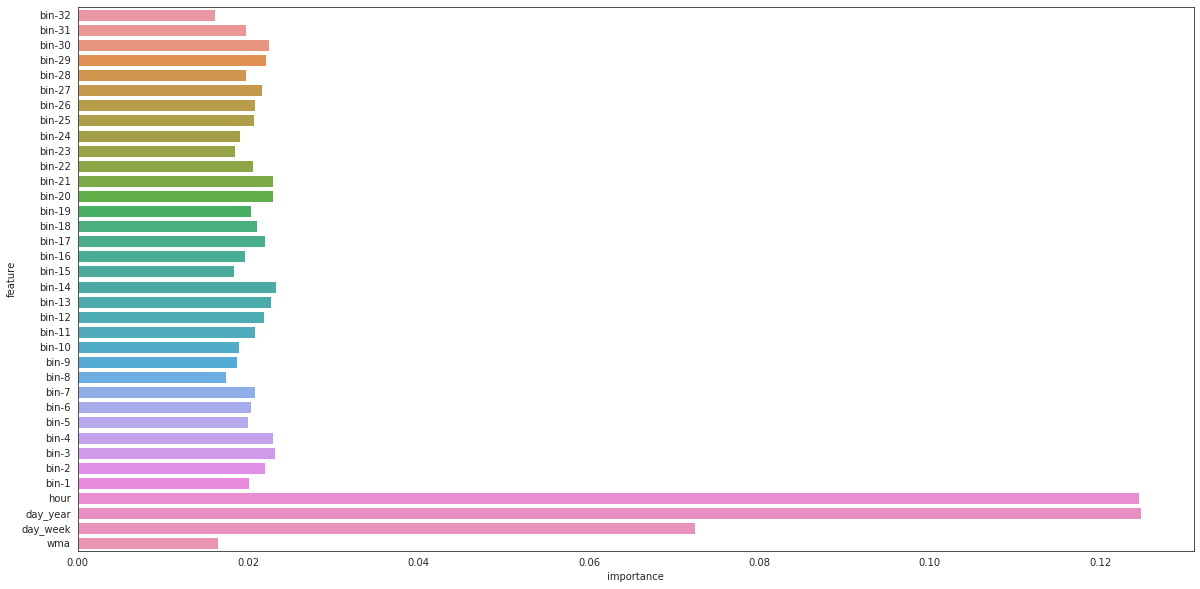

<Figure size 1440x720 with 0 Axes>

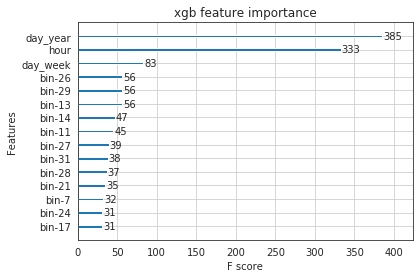

0.5900490514300918
isolating post data for the 2 post
entries for post 2: 71430
creating time bins
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
total expected time bins for the bin length of 90 minutes is 30063 and 360756 bins for  the post
**--**

pivot point for T/F:  2
mean for incidents:  1.7351497584541062
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


We currently have 25875 total time bins populated for the post leaving   4188 empty time bins.
creating list of time bins with recorded incidents
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
Filling in 0 for all empty incident entries for all time bins   for the post
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**

number of 90 min intervals for post number 2
which is 2705670 total minutes or 1878.9375 days or 5.14777397260274 years
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
creating the baseline dataframe for use with the baseline models
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
base dataframe completed
**--****--****--****--****--****--****--****--****--****--****--****--****--****--

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


Training scores for random forest
[[  899    89  2218]
 [    9  1669  3510]
 [    6    20 12601]]
              precision    recall  f1-score   support

           0       0.98      0.28      0.44      3206
           1       0.94      0.32      0.48      5188
           2       0.69      1.00      0.81     12627

    accuracy                           0.72     21021
   macro avg       0.87      0.53      0.58     21021
weighted avg       0.79      0.72      0.67     21021

Training score for random forest is: 0.7216117216117216
Test scores random forest


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


[[  21   48  907]
 [  15   74 1568]
 [  25   91 6261]]
              precision    recall  f1-score   support

           0       0.34      0.02      0.04       976
           1       0.35      0.04      0.08      1657
           2       0.72      0.98      0.83      6377

    accuracy                           0.71      9010
   macro avg       0.47      0.35      0.32      9010
weighted avg       0.61      0.71      0.61      9010

Test score for random forest is: 0.7054384017758046
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
Training scores for XGB
[[  490   446  2270]
 [  364   651  4173]
 [  289   429 11909]]
              precision    recall  f1-score   support

           0       0.43      0.15      0.23      3206
           1       0.43      0.13      0.19      5188
           2       

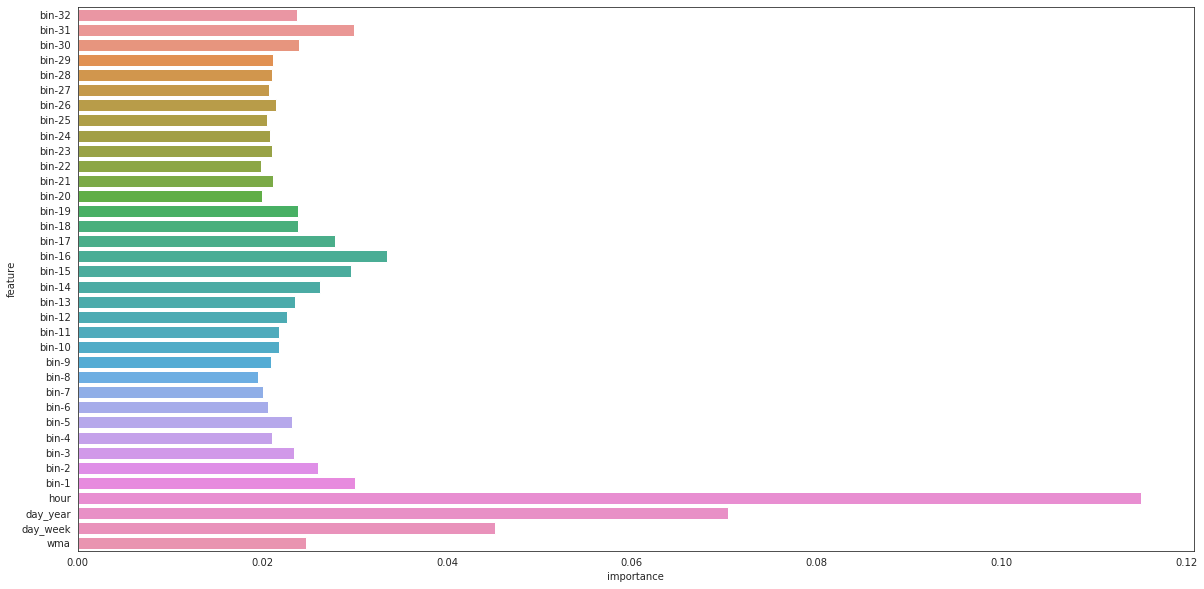

<Figure size 1440x720 with 0 Axes>

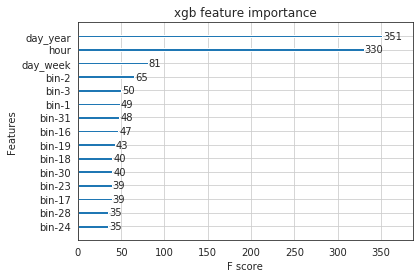

0.6021793237375804
isolating post data for the 3 post
entries for post 3: 20416
creating time bins
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
total expected time bins for the bin length of 90 minutes is 30063 and 360756 bins for  the post
**--**

pivot point for T/F:  1
mean for incidents:  1.3261506276150627
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
We currently have 14340 total time bins populated for the post leaving   15723 empty time bins.
creating list of time bins with recorded incidents
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
Filling in 0 for all empty incident entries for all time bins   for the post
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



number of 90 min intervals for post number 3
which is 2705670 total minutes or 1878.9375 days or 5.14777397260274 years
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
creating the baseline dataframe for use with the baseline models
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
base dataframe completed
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
****---- post 2 mean average ----****
For 2 window:
[[13493  2231     0]
 [ 4900  3193  1569]
 [    0  2191  2486]]
              precision    recall  f1-score   support

           0       0.73      0.86      0.79     15724
           1       0.42      0.33      0.37      9662
           2       0.61      0.53      0.57      4677

    accuracy                           0.64     30063
   macro avg       0.59      0.57     

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


Training scores for random forest
[[11195    12     0]
 [ 3122  3594     0]
 [ 2606   209   283]]
              precision    recall  f1-score   support

           0       0.66      1.00      0.80     11207
           1       0.94      0.54      0.68      6716
           2       1.00      0.09      0.17      3098

    accuracy                           0.72     21021
   macro avg       0.87      0.54      0.55     21021
weighted avg       0.80      0.72      0.67     21021



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


Training score for random forest is: 0.7169972884258599
Test scores random forest
[[4288  213    2]
 [2739  192    1]
 [1440  135    0]]
              precision    recall  f1-score   support

           0       0.51      0.95      0.66      4503
           1       0.36      0.07      0.11      2932
           2       0.00      0.00      0.00      1575

    accuracy                           0.50      9010
   macro avg       0.29      0.34      0.26      9010
weighted avg       0.37      0.50      0.37      9010

Test score for random forest is: 0.4972253052164262
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
Training scores for XGB
[[11107   100     0]
 [ 6511   202     3]
 [ 3014    83     1]]
              precision    recall  f1-score   support

           0       0.54      0.99      0.70  

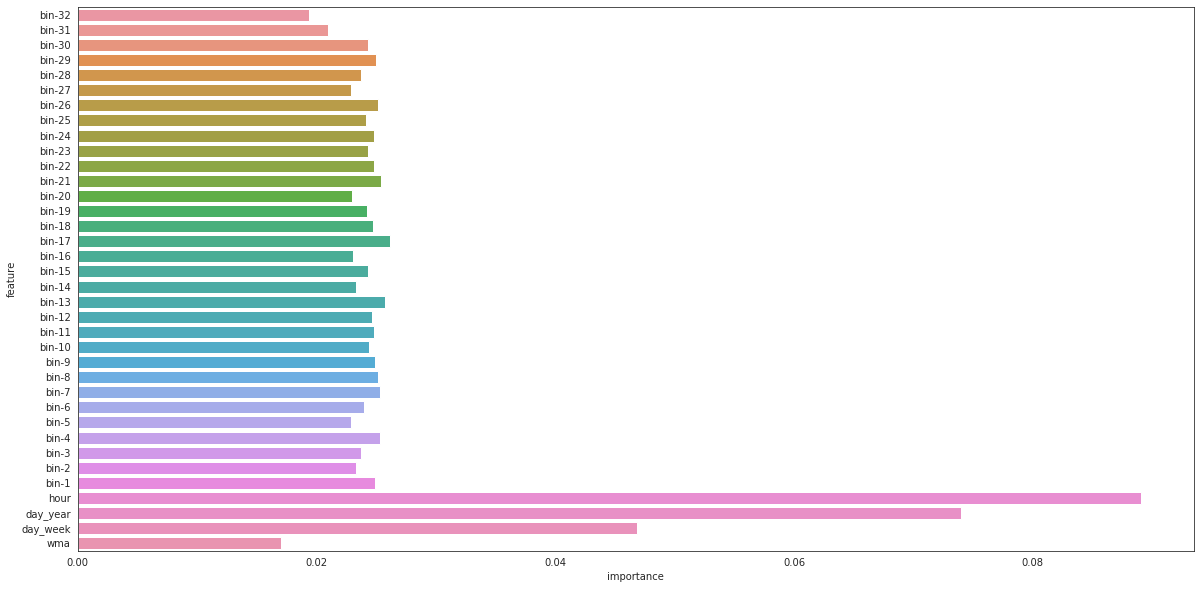

<Figure size 1440x720 with 0 Axes>

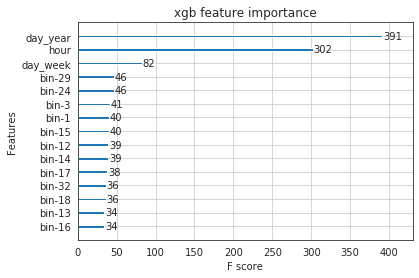

0.41968566524539186
isolating post data for the 4 post
entries for post 4: 26338
creating time bins
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
total expected time bins for the bin length of 90 minutes is 30060 and 360720 bins for  the post
**--**

pivot point for T/F:  1
mean for incidents:  1.3928762243989314
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
We currently have 16845 total time bins populated for the post leaving   13218 empty time bins.
creating list of time bins with recorded incidents
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
Filling in 0 for all empty incident entries for all time bins   for the post
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



number of 90 min intervals for post number 4
which is 2705670 total minutes or 1878.9375 days or 5.14777397260274 years
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
creating the baseline dataframe for use with the baseline models
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
base dataframe completed
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
****---- post 3 mean average ----****
For 2 window:
[[10764  2454     0]
 [ 4381  3499  2347]
 [    0  2490  4128]]
              precision    recall  f1-score   support

           0       0.71      0.81      0.76     13218
           1       0.41      0.34      0.37     10227
           2       0.64      0.62      0.63      6618

    accuracy                           0.61     30063
   macro avg       0.59      0.59     

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


Training scores for random forest
[[9391  115   11]
 [1635 5538    6]
 [1691  459 2175]]
              precision    recall  f1-score   support

           0       0.74      0.99      0.84      9517
           1       0.91      0.77      0.83      7179
           2       0.99      0.50      0.67      4325

    accuracy                           0.81     21021
   macro avg       0.88      0.75      0.78     21021
weighted avg       0.85      0.81      0.80     21021



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


Training score for random forest is: 0.8136625279482422
Test scores random forest
[[2895  708   82]
 [2159  785   91]
 [1436  743  111]]
              precision    recall  f1-score   support

           0       0.45      0.79      0.57      3685
           1       0.35      0.26      0.30      3035
           2       0.39      0.05      0.09      2290

    accuracy                           0.42      9010
   macro avg       0.40      0.36      0.32      9010
weighted avg       0.40      0.42      0.35      9010

Test score for random forest is: 0.4207547169811321
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
Training scores for XGB
[[7347 1942  228]
 [4432 2518  229]
 [2210 1764  351]]
              precision    recall  f1-score   support

           0       0.53      0.77      0.63      9517


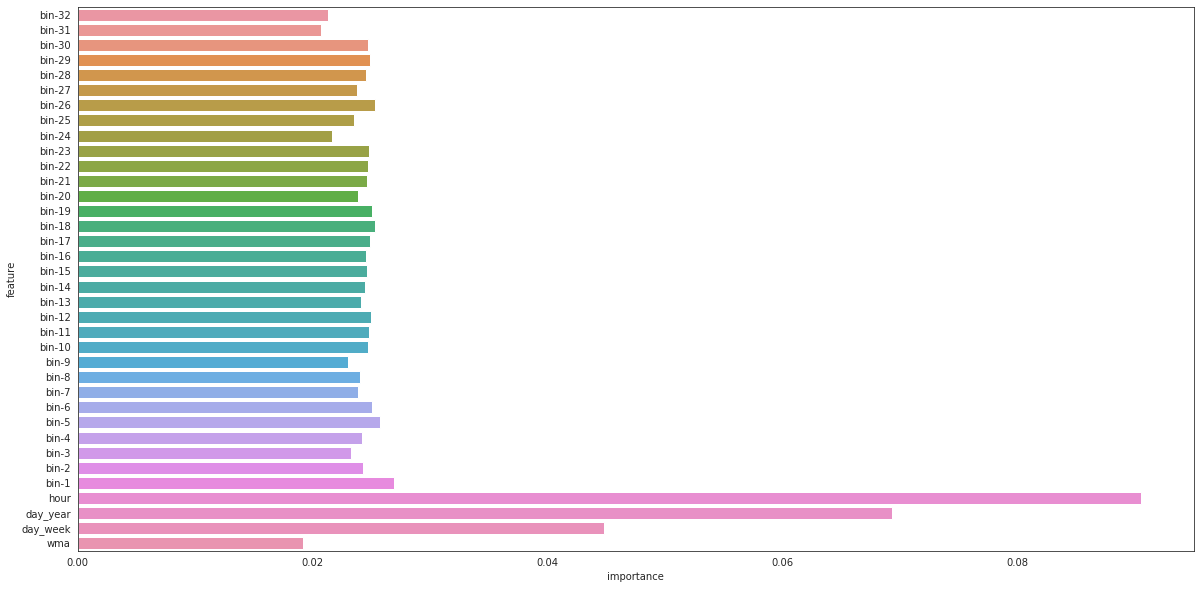

<Figure size 1440x720 with 0 Axes>

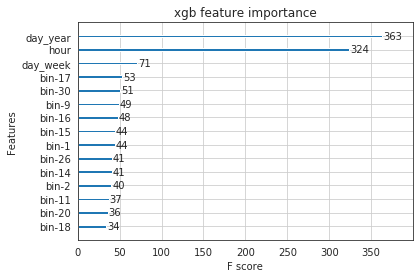

0.4077776063250249
isolating post data for the 5 post
entries for post 5: 55047
creating time bins
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
total expected time bins for the bin length of 90 minutes is 30063 and 360756 bins for  the post
**--**

pivot point for T/F:  2
mean for incidents:  1.6466246475369049
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
We currently have 24116 total time bins populated for the post leaving   5947 empty time bins.
creating list of time bins with recorded incidents
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Filling in 0 for all empty incident entries for all time bins   for the post
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**

number of 90 min intervals for post number 5
which is 2705670 total minutes or 1878.9375 days or 5.14777397260274 years
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
creating the baseline dataframe for use with the baseline models
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
base dataframe completed
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
****---- post 4 mean average ----****
For 2 window:
[[ 3410  2538     0]
 [ 1904  2545  4073]
 [    1  2493 13099]]
              precision    recall  f1-score   support

           0       0.64      0.57      0.61      5948
   

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Training scores for random forest
[[ 2207   142  2032]
 [   52  3371  2740]
 [   49    70 10358]]
              precision    recall  f1-score   support

           0       0.96      0.50      0.66      4381
           1       0.94      0.55      0.69      6163
           2       0.68      0.99      0.81     10477

    accuracy                           0.76     21021
   macro avg       0.86      0.68      0.72     21021
weighted avg       0.82      0.76      0.74     21021

Training score for random forest is: 0.7580990438133295
Test scores random forest


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


[[ 192  332 1035]
 [ 209  339 1805]
 [ 217  297 4584]]
              precision    recall  f1-score   support

           0       0.31      0.12      0.18      1559
           1       0.35      0.14      0.20      2353
           2       0.62      0.90      0.73      5098

    accuracy                           0.57      9010
   macro avg       0.43      0.39      0.37      9010
weighted avg       0.49      0.57      0.50      9010

Test score for random forest is: 0.5677025527192009
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
Training scores for XGB
[[1297  772 2312]
 [ 969 1073 4121]
 [ 691  717 9069]]
              precision    recall  f1-score   support

           0       0.44      0.30      0.35      4381
           1       0.42      0.17      0.25      6163
           2       0.59     

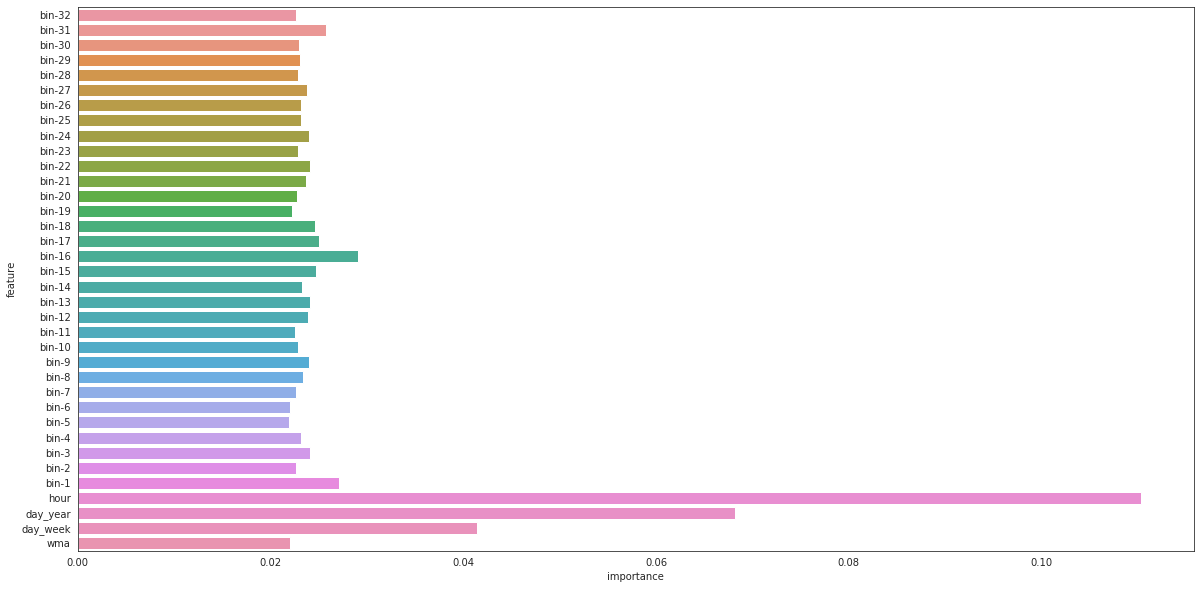

<Figure size 1440x720 with 0 Axes>

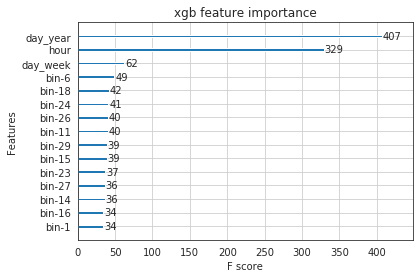

0.512934172824123
isolating post data for the 6 post
entries for post 6: 21539
creating time bins
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
total expected time bins for the bin length of 90 minutes is 30062 and 360744 bins for  the post
**--**

pivot point for T/F:  1
mean for incidents:  1.3360766324878575
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
We currently have 14824 total time bins populated for the post leaving   15239 empty time bins.
creating list of time bins with recorded incidents
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
Filling in 0 for all empty incident entries for all time bins   for the post
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



number of 90 min intervals for post number 6
which is 2705670 total minutes or 1878.9375 days or 5.14777397260274 years
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
creating the baseline dataframe for use with the baseline models
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
base dataframe completed
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
****---- post 5 mean average ----****
For 2 window:
[[13021  2218     0]
 [ 4892  3266  1684]
 [    1  2179  2802]]
              precision    recall  f1-score   support

           0       0.73      0.85      0.79     15239
           1       0.43      0.33      0.37      9842
           2       0.62      0.56      0.59      4982

    accuracy                           0.63     30063
   macro avg       0.59      0.58     

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


Training scores for random forest
[[10890    31     0]
 [ 2774  4066     0]
 [ 2369   338   553]]
              precision    recall  f1-score   support

           0       0.68      1.00      0.81     10921
           1       0.92      0.59      0.72      6840
           2       1.00      0.17      0.29      3260

    accuracy                           0.74     21021
   macro avg       0.87      0.59      0.61     21021
weighted avg       0.81      0.74      0.70     21021



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


Training score for random forest is: 0.7377860235003092
Test scores random forest
[[3969  323    5]
 [2696  296    2]
 [1457  255    7]]
              precision    recall  f1-score   support

           0       0.49      0.92      0.64      4297
           1       0.34      0.10      0.15      2994
           2       0.50      0.00      0.01      1719

    accuracy                           0.47      9010
   macro avg       0.44      0.34      0.27      9010
weighted avg       0.44      0.47      0.36      9010

Test score for random forest is: 0.47413984461709213
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
Training scores for XGB
[[10345   571     5]
 [ 6024   809     7]
 [ 2843   402    15]]
              precision    recall  f1-score   support

           0       0.54      0.95      0.69 

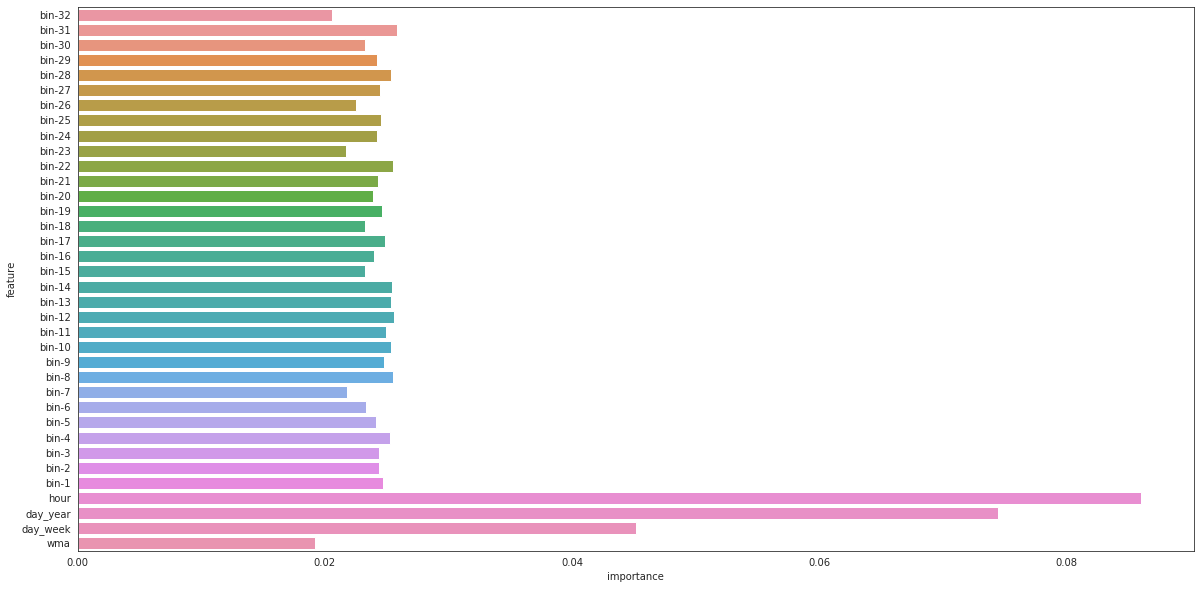

<Figure size 1440x720 with 0 Axes>

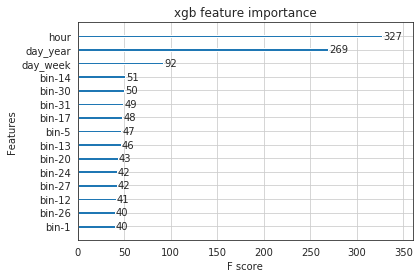

0.3792452477934438
isolating post data for the 7 post
entries for post 7: 32974
creating time bins
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
total expected time bins for the bin length of 90 minutes is 30063 and 360756 bins for  the post
**--**

pivot point for T/F:  1
mean for incidents:  1.4600031105811602
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
We currently have 19289 total time bins populated for the post leaving   10774 empty time bins.
creating list of time bins with recorded incidents
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
Filling in 0 for all empty incident entries for all time bins   for the post
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



number of 90 min intervals for post number 7
which is 2705670 total minutes or 1878.9375 days or 5.14777397260274 years
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
creating the baseline dataframe for use with the baseline models
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
base dataframe completed
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
****---- post 6 mean average ----****
For 2 window:
[[8096 2679    0]
 [3717 3655 3043]
 [   0 2707 6166]]
              precision    recall  f1-score   support

           0       0.69      0.75      0.72     10775
           1       0.40      0.35      0.38     10415
           2       0.67      0.69      0.68      8873

    accuracy                           0.60     30063
   macro avg       0.59      0.60      0.59    

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


Training scores for random forest
[[7466  266  190]
 [ 818 6399   97]
 [ 907  347 4531]]
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      7922
           1       0.91      0.87      0.89      7314
           2       0.94      0.78      0.85      5785

    accuracy                           0.88     21021
   macro avg       0.89      0.87      0.87     21021
weighted avg       0.88      0.88      0.87     21021



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


Training score for random forest is: 0.8751248751248751
Test scores random forest
[[1671  774  396]
 [1530  972  584]
 [1007 1241  835]]
              precision    recall  f1-score   support

           0       0.40      0.59      0.47      2841
           1       0.33      0.31      0.32      3086
           2       0.46      0.27      0.34      3083

    accuracy                           0.39      9010
   macro avg       0.39      0.39      0.38      9010
weighted avg       0.39      0.39      0.38      9010

Test score for random forest is: 0.386015538290788
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
Training scores for XGB
[[4611 1689 1622]
 [2919 2522 1873]
 [1435 1809 2541]]
              precision    recall  f1-score   support

           0       0.51      0.58      0.55      7922
 

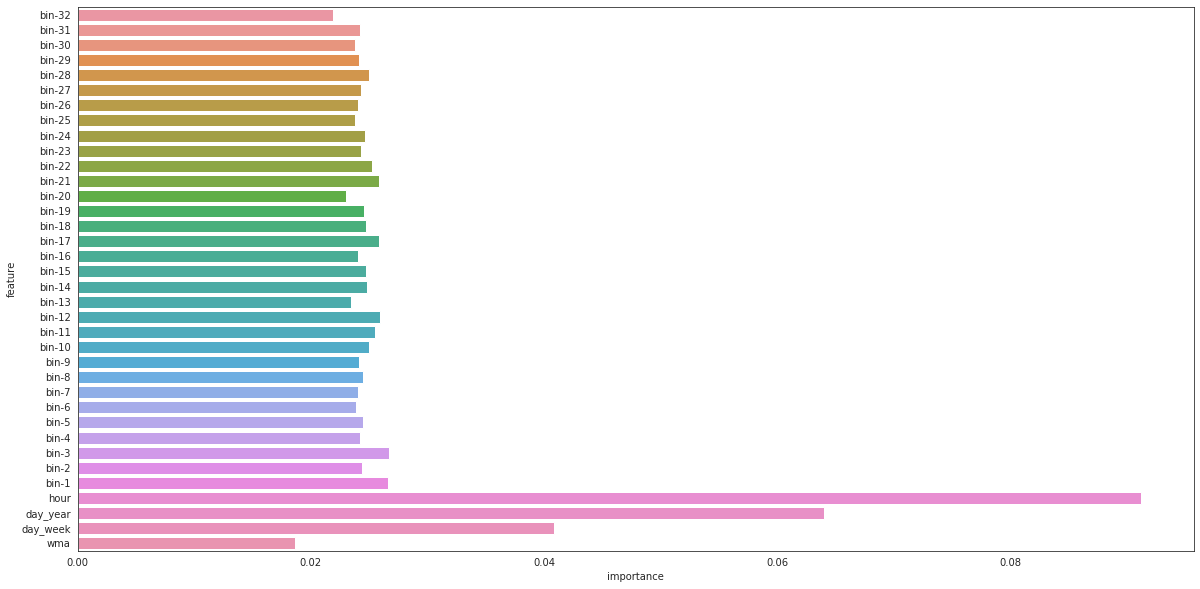

<Figure size 1440x720 with 0 Axes>

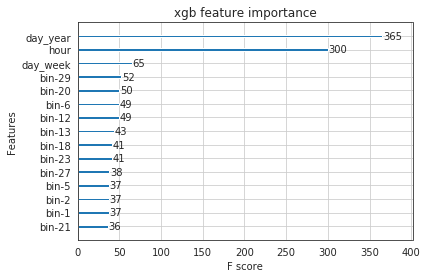

0.4148477960086078
isolating post data for the 8 post
entries for post 8: 38843
creating time bins
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
total expected time bins for the bin length of 90 minutes is 30063 and 360756 bins for  the post
**--**

pivot point for T/F:  1
mean for incidents:  1.5194867146877833
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
We currently have 20963 total time bins populated for the post leaving   9100 empty time bins.
creating list of time bins with recorded incidents
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
Filling in 0 for all empty incident entries for all time bins   for the post
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



number of 90 min intervals for post number 8
which is 2705670 total minutes or 1878.9375 days or 5.14777397260274 years
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
creating the baseline dataframe for use with the baseline models
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
base dataframe completed
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
****---- post 7 mean average ----****
For 2 window:
[[6331 2770    0]
 [3088 3376 3608]
 [   0 2769 8121]]
              precision    recall  f1-score   support

           0       0.67      0.70      0.68      9101
           1       0.38      0.34      0.36     10072
           2       0.69      0.75      0.72     10890

    accuracy                           0.59     30063
   macro avg       0.58      0.59      0.59    

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Training scores for random forest
[[5003  247 1105]
 [ 342 5940  755]
 [ 498  169 6962]]
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      6355
           1       0.93      0.84      0.89      7037
           2       0.79      0.91      0.85      7629

    accuracy                           0.85     21021
   macro avg       0.86      0.85      0.85     21021
weighted avg       0.86      0.85      0.85     21021



[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


Training score for random forest is: 0.851767280338709
Test scores random forest
[[1102  594 1042]
 [ 908  612 1502]
 [ 525  603 2122]]
              precision    recall  f1-score   support

           0       0.43      0.40      0.42      2738
           1       0.34      0.20      0.25      3022
           2       0.45      0.65      0.54      3250

    accuracy                           0.43      9010
   macro avg       0.41      0.42      0.40      9010
weighted avg       0.41      0.43      0.41      9010

Test score for random forest is: 0.42574916759156495
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
Training scores for XGB
[[3214  573 2568]
 [2256  900 3881]
 [1214  540 5875]]
              precision    recall  f1-score   support

           0       0.48      0.51      0.49      6355


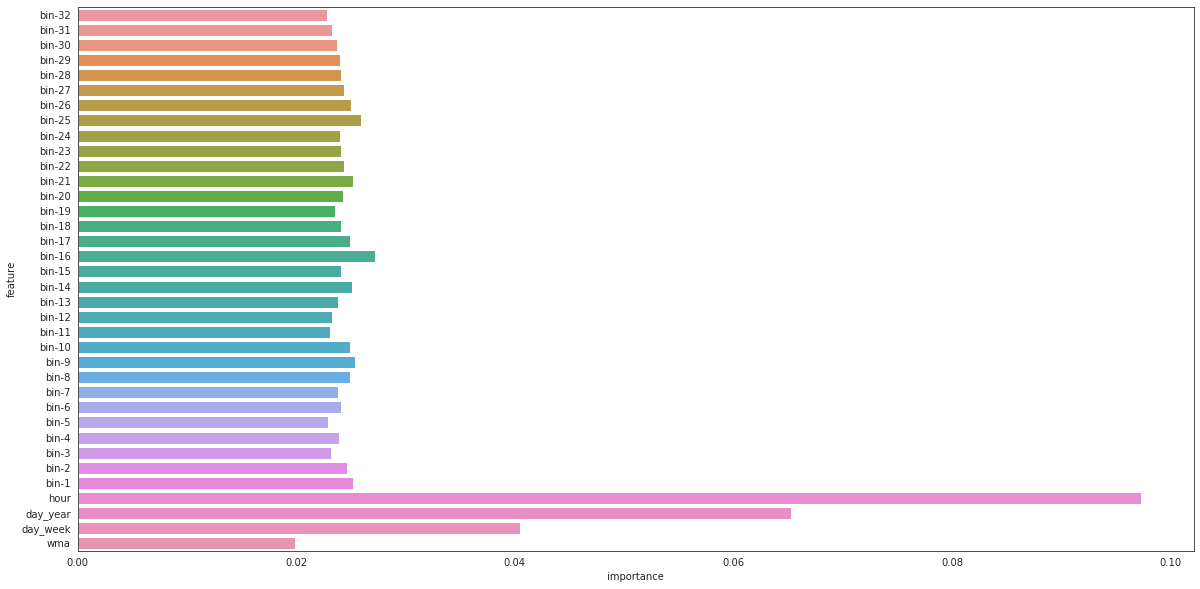

<Figure size 1440x720 with 0 Axes>

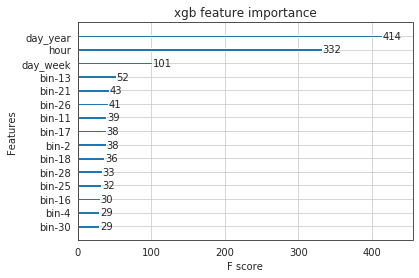

0.4211508226775339
isolating post data for the 9 post
entries for post 9: 12864
creating time bins
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
total expected time bins for the bin length of 90 minutes is 30062 and 360744 bins for  the post
**--**

pivot point for T/F:  1
mean for incidents:  1.2256031511570655
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
We currently have 10155 total time bins populated for the post leaving   19908 empty time bins.
creating list of time bins with recorded incidents
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
Filling in 0 for all empty incident entries for all time bins   for the post
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



number of 90 min intervals for post number 9
which is 2705670 total minutes or 1878.9375 days or 5.14777397260274 years
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
creating the baseline dataframe for use with the baseline models
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
base dataframe completed
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
****---- post 8 mean average ----****
For 2 window:
[[18524  1384     0]
 [ 5038  2149   677]
 [    0  1367   924]]
              precision    recall  f1-score   support

           0       0.79      0.93      0.85     19908
           1       0.44      0.27      0.34      7864
           2       0.58      0.40      0.47      2291

    accuracy                           0.72     30063
   macro avg       0.60      0.54     

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


Training scores for random forest
[[14200     0     0]
 [ 5055   305     0]
 [ 1460     1     0]]
              precision    recall  f1-score   support

           0       0.69      1.00      0.81     14200
           1       1.00      0.06      0.11      5360
           2       0.00      0.00      0.00      1461

    accuracy                           0.69     21021
   macro avg       0.56      0.35      0.31     21021
weighted avg       0.72      0.69      0.58     21021

Training score for random forest is: 0.6900242614528329
Test scores random forest


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


[[5676    5    0]
 [2499    1    0]
 [ 828    1    0]]
              precision    recall  f1-score   support

           0       0.63      1.00      0.77      5681
           1       0.14      0.00      0.00      2500
           2       0.00      0.00      0.00       829

    accuracy                           0.63      9010
   macro avg       0.26      0.33      0.26      9010
weighted avg       0.44      0.63      0.49      9010

Test score for random forest is: 0.6300776914539401
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
Training scores for XGB
[[14199     1     0]
 [ 5358     2     0]
 [ 1461     0     0]]
              precision    recall  f1-score   support

           0       0.68      1.00      0.81     14200
           1       0.67      0.00      0.00      5360
           2       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training score for XGB is: 0.6755625327053898
Test scores for XGB
[[5680    1    0]
 [2499    1    0]
 [ 828    1    0]]
              precision    recall  f1-score   support

           0       0.63      1.00      0.77      5681
           1       0.33      0.00      0.00      2500
           2       0.00      0.00      0.00       829

    accuracy                           0.63      9010
   macro avg       0.32      0.33      0.26      9010
weighted avg       0.49      0.63      0.49      9010

Test score for XGB descent is: 0.6305216426193119


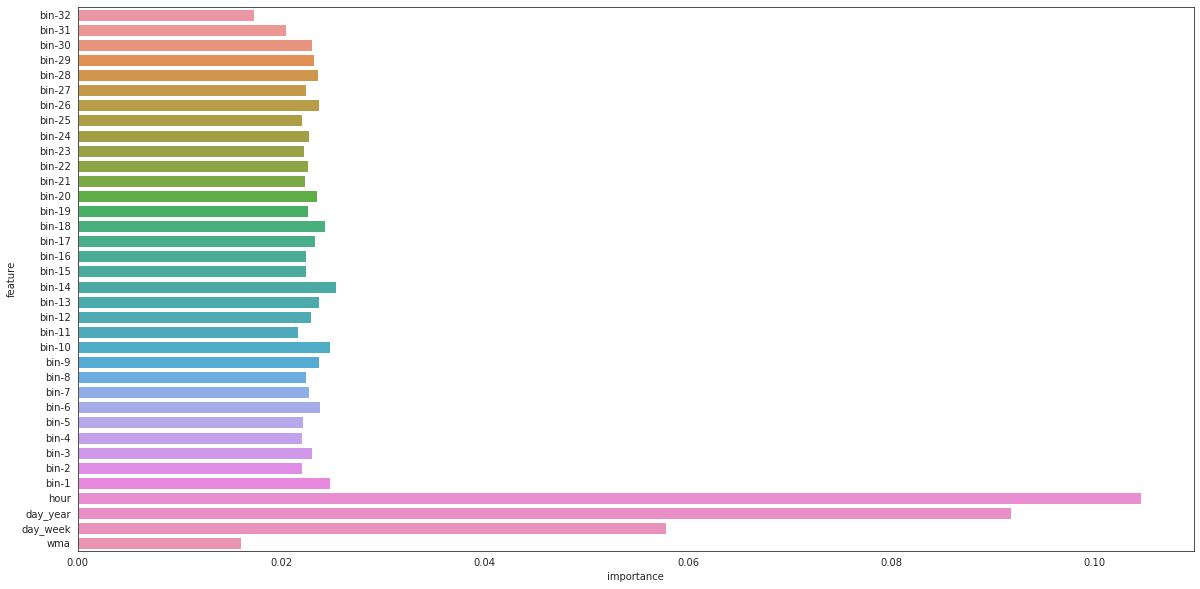

<Figure size 1440x720 with 0 Axes>

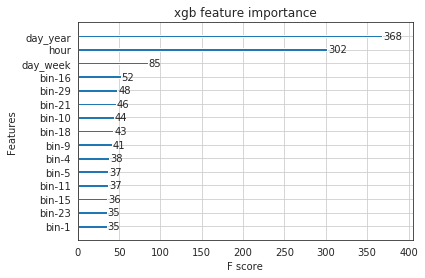

0.4901097806076016
isolating post data for the 10 post
entries for post 10: 31380
creating time bins
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
total expected time bins for the bin length of 90 minutes is 30063 and 360756 bins for  the post
**--**

pivot point for T/F:  1
mean for incidents:  1.446177680431647
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
We currently have 18719 total time bins populated for the post leaving   11344 empty time bins.
creating list of time bins with recorded incidents
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
Filling in 0 for all empty incident entries for all time bins   for the post
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



number of 90 min intervals for post number 10
which is 2705670 total minutes or 1878.9375 days or 5.14777397260274 years
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
creating the baseline dataframe for use with the baseline models
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
base dataframe completed
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
****---- post 9 mean average ----****
For 2 window:
[[8723 2622    0]
 [3928 3506 2932]
 [   1 2642 5709]]
              precision    recall  f1-score   support

           0       0.69      0.77      0.73     11345
           1       0.40      0.34      0.37     10366
           2       0.66      0.68      0.67      8352

    accuracy                           0.60     30063
   macro avg       0.58      0.60      0.59   

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Training scores for random forest
[[8104  194   74]
 [ 891 6349   59]
 [1178  438 3734]]
              precision    recall  f1-score   support

           0       0.80      0.97      0.87      8372
           1       0.91      0.87      0.89      7299
           2       0.97      0.70      0.81      5350

    accuracy                           0.87     21021
   macro avg       0.89      0.85      0.86     21021
weighted avg       0.88      0.87      0.86     21021



[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


Training score for random forest is: 0.865182436611008
Test scores random forest
[[1813  832  319]
 [1560 1031  461]
 [1211 1162  621]]
              precision    recall  f1-score   support

           0       0.40      0.61      0.48      2964
           1       0.34      0.34      0.34      3052
           2       0.44      0.21      0.28      2994

    accuracy                           0.38      9010
   macro avg       0.39      0.39      0.37      9010
weighted avg       0.39      0.38      0.37      9010

Test score for random forest is: 0.38457269700332963
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
Training scores for XGB
[[5487 1935  950]
 [3485 2608 1206]
 [1905 1810 1635]]
              precision    recall  f1-score   support

           0       0.50      0.66      0.57      8372


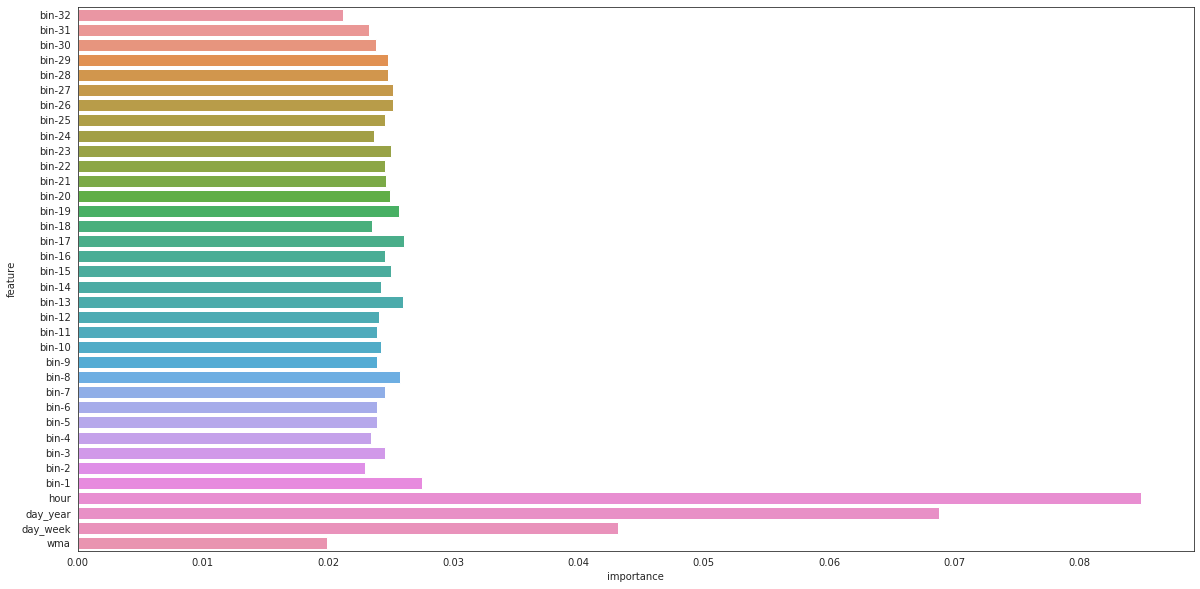

<Figure size 1440x720 with 0 Axes>

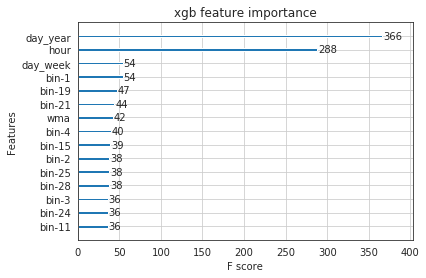

0.42129314344749935
isolating post data for the 11 post
entries for post 11: 2334
creating time bins
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
total expected time bins for the bin length of 90 minutes is 30051 and 360612 bins for  the post
**--**

pivot point for T/F:  1
mean for incidents:  1.0514440433212997
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
We currently have 2216 total time bins populated for the post leaving   27847 empty time bins.
creating list of time bins with recorded incidents
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
Filling in 0 for all empty incident entries for all time bins   for the post
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



number of 90 min intervals for post number 11
which is 2705670 total minutes or 1878.9375 days or 5.14777397260274 years
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
creating the baseline dataframe for use with the baseline models
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
base dataframe completed
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
****---- post 10 mean average ----****
For 2 window:
[[27751    96     0]
 [ 1927   159    16]
 [    0   104    10]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.96     27847
           1       0.44      0.08      0.13      2102
           2       0.38      0.09      0.14       114

    accuracy                           0.93     30063
   macro avg       0.59      0.39   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[27751    96     0]
 [    0  2102     0]
 [    0   104    10]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27847
           1       0.91      1.00      0.95      2102
           2       1.00      0.09      0.16       114

    accuracy                           0.99     30063
   macro avg       0.97      0.69      0.70     30063
weighted avg       0.99      0.99      0.99     30063

Accuracy:0.993347303994944, precision 0.9939252966973814, recall 0.993347303994944, RMSE: 0.08156406074403143
For 2 window:
[[27751    96     0]
 [    0  2102     0]
 [    0   104    10]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27847
           1       0.91      1.00      0.95      2102
           2       1.00      0.09      0.16       114

    accuracy                           0.99     30063
   macro avg       0.97      0.69      0.70     30063
weighted avg       0.99      0.99      0.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


Training scores for random forest
[[19489     0     0]
 [ 1461     0     0]
 [   71     0     0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     19489
           1       0.00      0.00      0.00      1461
           2       0.00      0.00      0.00        71

    accuracy                           0.93     21021
   macro avg       0.31      0.33      0.32     21021
weighted avg       0.86      0.93      0.89     21021

Training score for random forest is: 0.92712049854907
Test scores random forest
[[8328    0    0]
 [ 639    0    0]
 [  43    0    0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


              precision    recall  f1-score   support

           0       0.92      1.00      0.96      8328
           1       0.00      0.00      0.00       639
           2       0.00      0.00      0.00        43

    accuracy                           0.92      9010
   macro avg       0.31      0.33      0.32      9010
weighted avg       0.85      0.92      0.89      9010

Test score for random forest is: 0.9243063263041066
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
Training scores for XGB
[[19489     0     0]
 [ 1461     0     0]
 [   71     0     0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     19489
           1       0.00      0.00      0.00      1461
           2       0.00      0.00      0.00        71

    accuracy       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training score for XGB is: 0.92712049854907
Test scores for XGB
[[8328    0    0]
 [ 639    0    0]
 [  43    0    0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      8328
           1       0.00      0.00      0.00       639
           2       0.00      0.00      0.00        43

    accuracy                           0.92      9010
   macro avg       0.31      0.33      0.32      9010
weighted avg       0.85      0.92      0.89      9010

Test score for XGB descent is: 0.9243063263041066


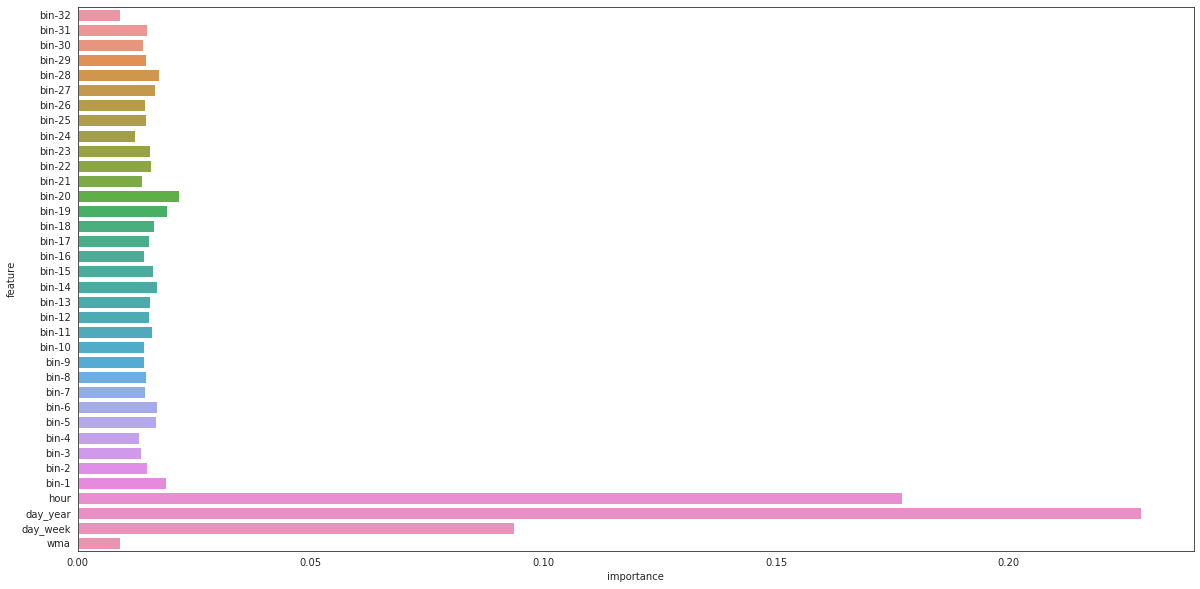

<Figure size 1440x720 with 0 Axes>

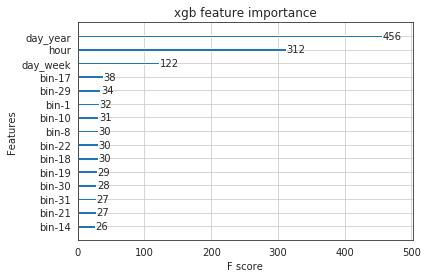

0.8543421848457935
isolating post data for the 12 post
entries for post 12: 13256
creating time bins
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
total expected time bins for the bin length of 90 minutes is 30063 and 360756 bins for  the post
**--**

pivot point for T/F:  1
mean for incidents:  1.2316553727008712
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
We currently have 10330 total time bins populated for the post leaving   19733 empty time bins.
creating list of time bins with recorded incidents
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
Filling in 0 for all empty incident entries for all time bins   for the post
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



number of 90 min intervals for post number 12
which is 2705670 total minutes or 1878.9375 days or 5.14777397260274 years
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
creating the baseline dataframe for use with the baseline models
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
base dataframe completed
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
****---- post 11 mean average ----****
For 2 window:
[[18350  1384     0]
 [ 4936  2253   748]
 [    0  1377  1015]]
              precision    recall  f1-score   support

           0       0.79      0.93      0.85     19734
           1       0.45      0.28      0.35      7937
           2       0.58      0.42      0.49      2392

    accuracy                           0.72     30063
   macro avg       0.60      0.55   

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


Training scores for random forest
[[13911     0     0]
 [ 4923   585     0]
 [ 1597     5     0]]
              precision    recall  f1-score   support

           0       0.68      1.00      0.81     13911
           1       0.99      0.11      0.19      5508
           2       0.00      0.00      0.00      1602

    accuracy                           0.69     21021
   macro avg       0.56      0.37      0.33     21021
weighted avg       0.71      0.69      0.59     21021

Training score for random forest is: 0.6895961181675467
Test scores random forest


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


[[5789   12    0]
 [2413    6    0]
 [ 785    5    0]]
              precision    recall  f1-score   support

           0       0.64      1.00      0.78      5801
           1       0.26      0.00      0.00      2419
           2       0.00      0.00      0.00       790

    accuracy                           0.64      9010
   macro avg       0.30      0.33      0.26      9010
weighted avg       0.48      0.64      0.51      9010

Test score for random forest is: 0.6431742508324084
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
**--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--****--**
Training scores for XGB
[[13911     0     0]
 [ 5503     5     0]
 [ 1600     0     2]]
              precision    recall  f1-score   support

           0       0.66      1.00      0.80     13911
           1       1.00      0.00      0.00      5508
           2       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


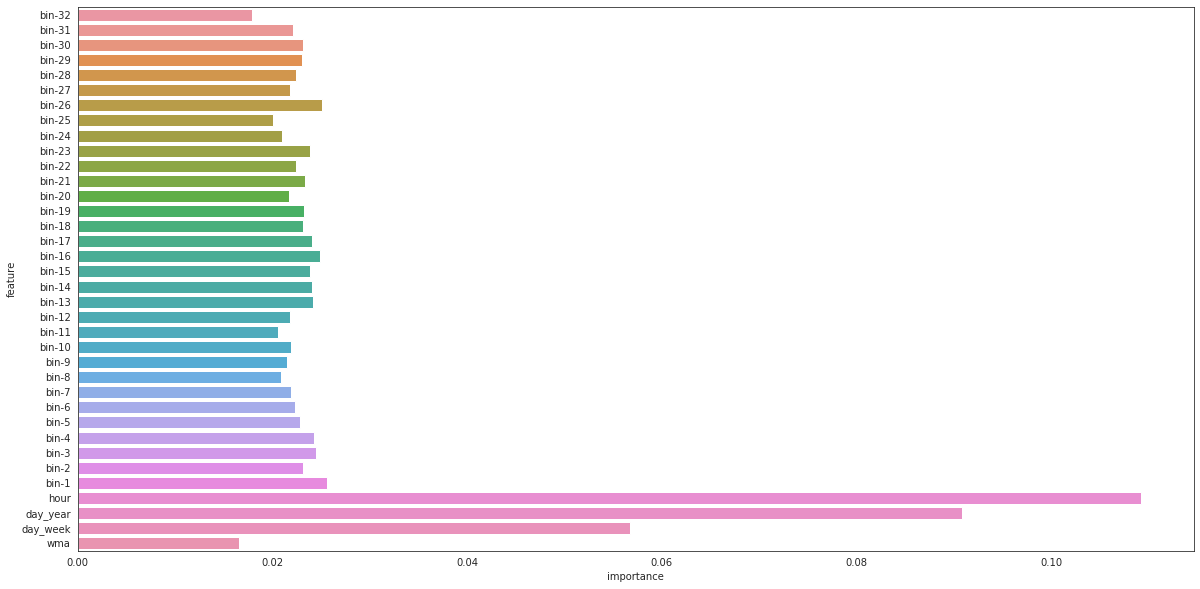

<Figure size 1440x720 with 0 Axes>

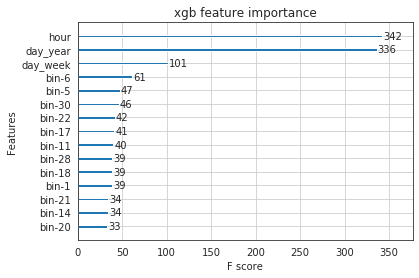

0.4145761871622027


In [238]:
res_prec = pd.DataFrame()


for i in range(0,12):
  data_isol, test = post_prep(i)

  res_prec = res_prec.append(test, ignore_index=True)
  

In [240]:
res_prec.head(15)

,xgbte_prec,forte_prec,clfte_prec,ewa_prec,wma_prec,ma_prec
0,0.590,0.768,0.632,0.909,0.963,0.744
1,0.602,0.608,0.611,0.870,0.915,0.664
2,0.420,0.369,0.424,0.859,0.899,0.599
3,0.408,0.400,0.394,0.849,0.889,0.584
4,0.513,0.495,0.490,0.857,0.895,0.610
5,0.379,0.441,0.433,0.858,0.899,0.593
6,0.415,0.394,0.396,0.842,0.882,0.573
7,0.421,0.410,0.398,0.844,0.881,0.574
8,0.490,0.481,0.500,0.887,0.932,0.661
9,0.421,0.393,0.396,0.844,0.884,0.571


In [243]:
print('xgboost', res_prec.xgbte_prec.mean())
print('random forest', res_prec.forte_prec.mean())
print('SGD SVM', res_prec.clfte_prec.mean())
print('exponential weighted average', res_prec.ewa_prec.mean())
print('weighted moving average', res_prec.wma_prec.mean())
print('moving average', res_prec.ma_prec.mean())


xgboost 0.49401591517540794
random forest 0.5178892312287465
SGD SVM 0.5056723757620754
exponential weighted average 0.8706166335600867
weighted moving average 0.9137172981096393
moving average 0.6437980700636766
